In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import scipy
import random

In [27]:
data_train = pd.read_csv('data_train.csv')

In [28]:
# Define the device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Create a PyTorch dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class SleepDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.from_numpy(self.sequences[idx]).float(), torch.from_numpy(np.array(self.labels[idx])).float()

In [29]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

# Create a function to impute the missing values in the dataset
def impute_missing_values (dataframe, method = 'LOCF', limit = 20):

    # create a missing mask (column) fthat would indicate whether the values in any of the columns of mydata are missing
    # 1 indicates missing, 0 indicates not missing
    missing_mask = dataframe.isnull().sum(axis=1).astype(bool).astype(int)
    dataframe_imputed = dataframe.copy()
    dataframe_imputed = pd.concat([dataframe_imputed, missing_mask.rename('ifmissing')], axis=1)

    if method == 'LOCF': 

        dataframe_imputed.fillna(method='ffill', inplace=True, limit = limit)

        # fill the rest with backward fill 
        dataframe_imputed.fillna(method='bfill', inplace=True, limit = limit)

    elif method =='NOCB':

        dataframe_imputed.fillna(method='bfill', inplace=True, limit = limit)

        # fill the rest with forward fill
        #dataframe_imputed.fillna(method='ffill', inplace=True, limit = limit)

    elif method == 'linear interpolation':
            
        dataframe_imputed.interpolate(method='linear', inplace=True, limit = limit)

    elif method == 'quadratic interpolation':

        dataframe_imputed.interpolate(method='quadratic', inplace=True, limit = limit)

    elif method == 'mean':

        dataframe_imputed.fillna(dataframe.mean(), inplace=True, limit = limit)

    elif method == 'median':

        dataframe_imputed.fillna(dataframe.median(), inplace=True, limit = limit)

    elif method == 'MICE':

        # Define an imputer
        imp = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, random_state=0),
                            missing_values=np.nan, 
                            sample_posterior=False,
                            max_iter=10, 
                            random_state=0, 
                            verbose=2)
                            

        columns = dataframe_imputed.columns

        # Apply the imputer
        df_imputed = imp.fit_transform(dataframe_imputed)

        # Convert back to DataFrame
        dataframe_imputed = pd.DataFrame(df_imputed, columns=columns)
    
    elif method == 'None':
        dataframe_imputed = dataframe_imputed

    missing_mask_new = dataframe_imputed.isnull().sum(axis=1).astype(bool).astype(int)

    dataframe_imputed = pd.concat([dataframe_imputed, missing_mask_new.rename('ifmissing_after_imputation')], axis=1)

    return dataframe_imputed


In [30]:


# Create a function for creating sliding windows of selected length 

def create_sliding_windows(data,  window_size_minutes=5, 
                           ifmissing = True, random_seed = 42, ifoutputsubjects = 0, 
                           train_proportion = 0.6, ifoutput_end_points = 0, 
                           resampling_method = None, resampling_proportion = 0.5, iftest = True):

    # Assert whether therea are any NaNs in the data
    if not ifmissing:
        assert data.isnull().sum().sum() == 0, "There are NaNs in the data"

    
    # Create a list of all unique subjects
    subjects = data['Sbj_ID'].unique()

    # Randomly select some of the 80% of subjects to be in the training set, 20% to the validation set and 20% in the test set
    np.random.seed(random_seed)


    train_subjects = np.random.choice(subjects, size=int(train_proportion*len(subjects)), replace=False)
    

    if iftest == 1:
        val_proportions = (1 - train_proportion)/2
        val_subjects = np.random.choice(np.setdiff1d(subjects, train_subjects), size=int(val_proportions*len(subjects)), replace=False)
        test_subjects = np.setdiff1d(subjects, np.concatenate((train_subjects, val_subjects)))
    else: 
        val_proportions = 1 - train_proportion
        val_subjects = np.setdiff1d(subjects, train_subjects)
        test_subjects = []

    
    
    # Print the number of subjects in each set
    print(f'There are {len(train_subjects)} subjects in the training set, {len(val_subjects)} subjects in the validation set and {len(test_subjects)} subjects in the test set')
    
    
    # Create a new column in the dataframe that indicates whether the subject is in the training set, val set or the test set
    data['Set'] = 'train'
    data.loc[data['Sbj_ID'].isin(val_subjects), 'Set'] = 'val'
    data.loc[data['Sbj_ID'].isin(test_subjects), 'Set'] = 'test'

    # Sort your dataframe by Sbj_ID if not already sorted
    data = data.sort_values('Sbj_ID')

    # Convert the window size from minutes to 6-second epochs
    window_size = int((window_size_minutes*60)/6)

    # Create empty lists to store your sequences and labels
    train_sequences = []
    train_labels = []
    val_sequences = []
    val_labels = []
    test_sequences = []
    test_labels = []

    # Group the DataFrame by subject ID and iterate over each group, dividing into training and test sets
    if ifoutput_end_points == 1:
        test_end_points = []
        test_sleep_stages = []
        test_labels = []
        val_sleep_stages = []
        val_end_points = []
    for _, group in data.groupby('Sbj_ID'):
        
        # For each group, get the feature columns and convert them into numpy array
        if ifoutput_end_points == 1:
             group_features = group.drop(['Sbj_ID', 'Label', 'Set', 'ifmissing_after_imputation', 'Old_label', 'ifCleanOnset', 'Time2Sleep', 'SleepStage'], axis=1).to_numpy()
             group_old_labels = group['Old_label'].to_numpy()
             group_sleep_stages = group['SleepStage'].to_numpy()
             group_labels = group['Label'].to_numpy()
        else:
            group_features = group.drop(['Sbj_ID', 'Label', 'Set', 'ifmissing_after_imputation', 'ifCleanOnset', 'Time2Sleep', 'SleepStage'], axis=1).to_numpy()

        ifmissing_column = group['ifmissing_after_imputation'].to_numpy()

        train_test = group['Set'].iloc[0]
        
        if window_size == len(group_features):
            if train_test == 'train':
                print('got here')
                train_sequences.append(group_features)
                train_labels.append(group['Label'].iloc[0])
            elif train_test == 'val':
                val_sequences.append(group_features)
                val_labels.append(group['Label'].iloc[0])
            elif train_test == 'test':
                test_sequences.append(group_features)
                test_labels.append(group['Label'].iloc[0])
        elif window_size > len(group_features):
            continue

       
        # Iterate over the group array with a sliding window
        for i in range(len(group_features) - window_size):
            
            # If there are any NaNs in the window, skip it
            if ifmissing_column[i : i + window_size].sum() > 0:
                continue

            if train_test == 'train':

                # Append the window data to your sequences
                train_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                train_labels.append(group['Label'].iloc[i+window_size])

                if ifoutput_end_points == 1:
                    # Append the starting point of the window to the list of starting points
                    test_end_points.append(group_old_labels[i+window_size])
                    test_sleep_stages.append(group_sleep_stages[i+window_size])
            
            elif train_test == 'val':
                # Append the window data to your sequences
                val_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                val_labels.append(group['Label'].iloc[i+window_size])

                if ifoutput_end_points == 1:
                    # Append the starting point of the window to the list of starting points
                    val_end_points.append(group_old_labels[i+window_size])
                    val_sleep_stages.append(group_sleep_stages[i+window_size])
            

            elif train_test == 'test':
                
                # Append the window data to your sequences
                test_sequences.append(group_features[i : i + window_size])

                # Append the label corresponding to the end of the window
                test_labels.append(group['Label'].iloc[i+window_size])
                        
            
    # Convert the sequences and labels into numpy arrays
    train_sequences = np.array(train_sequences)
    train_labels = np.array(train_labels)
    val_sequences = np.array(val_sequences)
    val_labels = np.array(val_labels)
    test_sequences = np.array(test_sequences)
    test_labels = np.array(test_labels)

    
    if iftest == 1:
        if ifoutputsubjects:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, train_subjects, val_subjects, test_subjects, test_end_points, test_sleep_stages
            else: 
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, train_subjects, val_subjects, test_subjects
        else:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels, test_end_points, test_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels,  test_sequences, test_labels
    else:
        if ifoutputsubjects:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels,  train_subjects, val_subjects, val_end_points, val_sleep_stages
            else: 
                return train_sequences, train_labels, val_sequences, val_labels, train_subjects, val_subjects
            
        else:
            if ifoutput_end_points == 1:
                return train_sequences, train_labels, val_sequences, val_labels, val_end_points, val_sleep_stages
            else:
                return train_sequences, train_labels, val_sequences, val_labels


In [31]:
import torch
from sklearn.metrics import mean_squared_error, r2_score

# Train function
def train_regression(model, train_loader, val_loader, num_epochs, criterion, optimizer, device, ifplot = False):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):

        print ('Epoch {}/{}'.format(epoch+1, num_epochs))

        # Train the model
        model.train()
        for i, (inputs, labels) in enumerate(train_loader):
           
            inputs, labels = inputs.permute(1, 0, 2).to(device), labels.to(device)
            # Your training steps...

            # Forward pass
            outputs = model(inputs)

            loss = criterion(outputs, labels.view(-1, 1))

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validate the model
        model.eval()
        with torch.no_grad():
            val_loss = 0
            predictions, actuals = [], []
            for inputs, labels in val_loader:
                inputs, labels = inputs.permute(1, 0, 2).to(device), labels.to(device)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)  # these are outputs now
                val_loss += criterion(outputs, labels.view(-1, 1)).item()

                predictions.extend(outputs.cpu().numpy().flatten())
                actuals.extend(labels.cpu().numpy())    

            # Calculate metrics
            mse = mean_squared_error(actuals, predictions)
            r2 = r2_score(actuals, predictions)
            mae = mean_absolute_error(actuals, predictions)

            if ifplot:
                print('-'*100)
                print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss/len(val_loader)}')
                print(f'Val Mean Squared Error: {mse}, Val R2 Score: {r2}')

                

        # Save the model training and validation losses for plotting 
        train_losses.append(loss.item())
        val_losses.append(val_loss/len(val_loader))

    return train_losses, val_losses, model, optimizer, mse, r2, mae

# Test function
def test_regression(model, test_loader, device, criterion):
    model.eval()
    predictions, actuals = [], []
    
    with torch.no_grad():
        test_loss = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.permute(1, 0, 2).to(device), labels.to(device)
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)  # these are outputs now
            test_loss += criterion(outputs, labels.view(-1, 1)).item()

            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(labels.cpu().numpy())

        print(f'Test Loss: {test_loss/len(test_loader)}')

    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    mae = mean_absolute_error(actuals, predictions)

    print('Mean Squared Error:', mse)
    print('R2 Score:', r2)
    print('Mean Absolute Error:', mae)

    return predictions, actuals, mse, r2, mae

In [32]:
def evaluate_performance_test(predictions, y_test):

    # check if the predictions are in the correct format
    if type(predictions) == list:
        predictions = np.array(predictions)

    # check if the y_test is in the correct format
    if type(y_test) == list:
        y_test = np.array(y_test)

    errors = abs(y_test - predictions)
    mape = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mape)
    mse = sklearn.metrics.mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = sklearn.metrics.r2_score(y_test, predictions)


    print('Mean Absolute Error:', round(np.mean(errors), 2))
    print('Accuracy:', round(accuracy, 2), '%.')
    print('Mean Squared Error:', round(mse, 2))
    print('Root Mean Squared Error:', round(rmse, 2))
    print('R2:', round(r2, 2))
    


    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
    plt.scatter(y_test, predictions, alpha=0.2)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Predicted time to sleep onset')
    plt.title('Actual vs Predicted time to sleep onset')
    plt.show()
    plt.close()

    residuals = y_test - predictions
    plt.scatter(y_test, residuals, alpha=0.2)
    plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1)
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Residuals')
    plt.title('Actual vs Residuals')
    plt.show()
    plt.close()

    plt.hist(residuals)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Residuals distribution')
    plt.show()
    plt.close()

    # for each actual, plot the mean residual 
    # round y_test to 0.1 decimal place
    y_test = np.round(y_test, 1)

    predictions_residuals_dict = {}
    for i in range(len(y_test)):
        if y_test[i] not in predictions_residuals_dict:
            predictions_residuals_dict[y_test[i]] = []
        predictions_residuals_dict[y_test[i]].append(residuals[i])
    
    # sort it in ascending order of keys
    predictions_residuals_dict = dict(sorted(predictions_residuals_dict.items()))


    actual_predictions_dict = {}
    for i in range(len(y_test)):
        if y_test[i] not in actual_predictions_dict:
            actual_predictions_dict[y_test[i]] = []
        actual_predictions_dict[y_test[i]].append(predictions[i])
    
    # sort it in ascending order of keys
    actual_predictions_dict = dict(sorted(actual_predictions_dict.items()))

    
    predictions_residuals_mean_dict = {}
    for key in predictions_residuals_dict:
        predictions_residuals_mean_dict[key] = np.mean(predictions_residuals_dict[key])
    
    # sort it in ascending order of keys
    predictions_residuals_mean_dict = dict(sorted(predictions_residuals_mean_dict.items()))


    residuals_std_dict = {}
    for key in predictions_residuals_dict:
        residuals_std_dict[key] = np.std(predictions_residuals_dict[key])
    # sort it in ascending order of keys
    residuals_std_dict = dict(sorted(residuals_std_dict.items()))

    
    actuals_predictions_mean_dict = {}
    for key in actual_predictions_dict:
        actuals_predictions_mean_dict[key] = np.mean(actual_predictions_dict[key])
    
    # sort it in ascending order of keys
    actuals_predictions_mean_dict = dict(sorted(actuals_predictions_mean_dict.items()))

    predictions_std_dict = {}
    for key in actual_predictions_dict:
        predictions_std_dict[key] = np.std(actual_predictions_dict[key])
    # sort it in ascending order of keys
    predictions_std_dict = dict(sorted(predictions_std_dict.items()))

    plt.plot(list(predictions_residuals_mean_dict.keys()), list(predictions_residuals_mean_dict.values()))
    # create std shading
    plt.fill_between(list(predictions_residuals_mean_dict.keys()),
                        np.array(list(predictions_residuals_mean_dict.values())) - np.array(list(residuals_std_dict.values())),
                        np.array(list(predictions_residuals_mean_dict.values())) + np.array(list(residuals_std_dict.values())),
                        alpha=0.2)
    # plot ideal line (x = 0)
    plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Mean Residuals for this actual')
    plt.title('Actual vs Residuals')
    plt.show()

    plt.plot(list(actuals_predictions_mean_dict.keys()), list(actuals_predictions_mean_dict.values()))
    # create std shading
    plt.fill_between(list(actuals_predictions_mean_dict.keys()),
                        np.array(list(actuals_predictions_mean_dict.values())) - np.array(list(predictions_std_dict.values())),
                        np.array(list(actuals_predictions_mean_dict.values())) + np.array(list(predictions_std_dict.values())),
                        alpha=0.2)
    # plot ideal line (x = y)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')
    plt.xlabel('Actual time to sleep onset')
    plt.ylabel('Mean Prediction for this actual')
    plt.title('Actual vs Predictions')
    plt.show()

    return predictions, errors, mape, accuracy, residuals

In [33]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class SleepOnsetTransformerRegressor(nn.Module):
    def __init__(self, input_size, nhead, num_layers, output_size=1, dropout=0.0):
        super(SleepOnsetTransformerRegressor, self).__init__()
        
        self.embedding = nn.Linear(input_size, 512) # Convert input features to suitable size for Transformer
        self.positional_encoding = PositionalEncoding(512, dropout)
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(d_model=512, nhead=nhead, dropout=dropout),
            num_layers=num_layers
        )
        
        self.fc = nn.Linear(512, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        out = self.fc(x[-1, :, :])  # using the last sequence output for regression prediction
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SleepOnsetTransformerRegressor(input_size=10, nhead=8, num_layers=2).to(device)



In [34]:
from sklearn.metrics import mean_squared_error

def training_loop_feature_RNN_regression(mydata, filling_limit, method, input_size, num_epochs,
                                        lr, weight_decay, batch_size, device, 
                                        nhead = 3, num_layers = 2, l2 = 0.01,
                                         random_seed=42, window_size_minutes=1, 
                                         iftest=False, ifoutputpredictions=0, 
                                         ifplot=False, ifsaveplots=True, output_path=None, loss_function = None,
                                         iftrainshuffle = False):

    # First, impute the missing values in the dataset
    mydata_imputed = impute_missing_values(mydata, method=method, limit=filling_limit)

    # Check if the dataset still has any missing values
    ifmissing = mydata_imputed.isnull().sum().sum()

   # Depending on the 'ifprobabilitiesanalysis' flag, process the data differently
    if iftest:
        train_sequences, train_targets, val_sequences, val_targets, test_sequences, test_targets = create_sliding_windows(mydata_imputed,  window_size_minutes=window_size_minutes,
                                                                                                                    ifmissing = ifmissing, random_seed = 42, ifoutputsubjects = 0, 
                                                                                                                    train_proportion = 0.9, ifoutput_end_points = 0,
                                                                                                                    resampling_method = None, resampling_proportion = 0.5, iftest = iftest)
    else:   
        train_sequences, train_targets, val_sequences, val_targets = create_sliding_windows(mydata_imputed,  window_size_minutes=window_size_minutes,
                                                                                                                    ifmissing = ifmissing, random_seed = 42, ifoutputsubjects = 0, 
                                                                                                                    train_proportion = 0.9, ifoutput_end_points = 0,
                                                                                                                    resampling_method = None, resampling_proportion = 0.5, iftest = iftest)
      
    
    # Define the loss function for regression
    if loss_function is None:
        criterion = nn.MSELoss()
    else:
        criterion = loss_function

    
    # Create the training, validation, and test datasets
    train_dataset = SleepDataset(train_sequences, train_targets)
    val_dataset = SleepDataset(val_sequences, val_targets)
    if iftest:
        test_dataset = SleepDataset(test_sequences, test_targets)

    # Create the data loaders
    if iftrainshuffle:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle =True)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle =False)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    if iftest:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    # Initialize the model (This model needs to be defined as a regression model)
    model = SleepOnsetTransformerRegressor(input_size=input_size, nhead = nhead,  num_layers = num_layers)

    # Define the optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train the model
    train_losses, val_losses, model, optimizer, mse, r2, mae= train_regression(model=model, train_loader=train_loader, val_loader=val_loader, device=device, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs, ifplot=ifplot)
    # Plot the training and validation losses
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    
    plt.show()
    plt.close()

    # Test the trained model if necessary
    if iftest == 1:
        predictions, actuals, mse, r2, mae = test_regression(model=model, test_loader=test_loader, device=device, criterion=criterion)
        #mse = mean_squared_error(actuals, predictions)
        print("Test MSE:", mse)
        print("Test R2:", r2)
        print("Test MAE:", mae)

        evaluate_performance_test(predictions, actuals)

    else:
        predictions, actuals, mse, r2, mae = test_regression(model=model, test_loader=val_loader, device=device, criterion=criterion)
        #mse = mean_squared_error(actuals, predictions)
        print("Test MSE:", mse)
        print("Test R2:", r2)
        print("Test MAE:", mae)

        evaluate_performance_test(predictions, actuals)
        if ifoutputpredictions:
            return train_losses, val_losses, model, predictions, actuals, mse
        else:
            return train_losses, val_losses, model


## Regression from pretrained model

In [35]:
data_clean_onset = pd.read_csv('data_train_clean_onset.csv')

There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/30
----------------------------------------------------------------------------------------------------
Epoch 1/30, Loss: 49.230995178222656, Validation Loss: 76.60709973956857
Val Mean Squared Error: 76.61914825439453, Val R2 Score: 0.06861472624124798
Epoch 2/30
----------------------------------------------------------------------------------------------------
Epoch 2/30, Loss: 50.58250427246094, Validation Loss: 74.4305875703886
Val Mean Squared Error: 74.44434356689453, Val R2 Score: 0.09505172849180232
Epoch 3/30
----------------------------------------------------------------------------------------------------
Epoch 3/30, Loss: 21.177566528320312, Validation Loss: 67.24449679603825
Val Mean Squared Error: 67.25236511230469, Val R2 Score: 0.18247767230940426
Epoch 4/30
------------------------------------------------------------------------------------------------

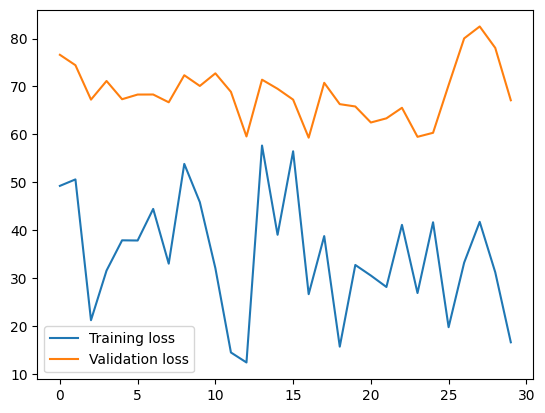

Test Loss: 67.10861347712479
Mean Squared Error: 67.10488
R2 Score: 0.1842705097607722
Mean Absolute Error: 6.9056664
Test MSE: 67.10488
Test R2: 0.1842705097607722
Test MAE: 6.9056664
Mean Absolute Error: 6.91
Accuracy: -inf %.
Mean Squared Error: 67.1
Root Mean Squared Error: 8.19
R2: 0.18


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


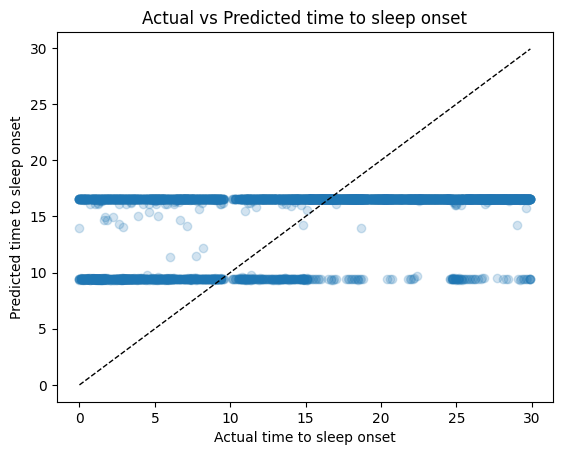

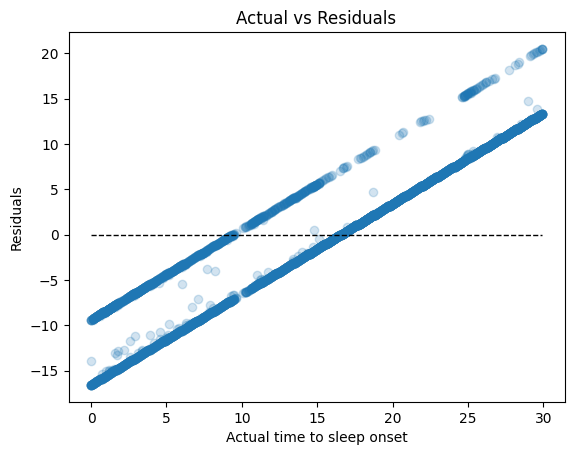

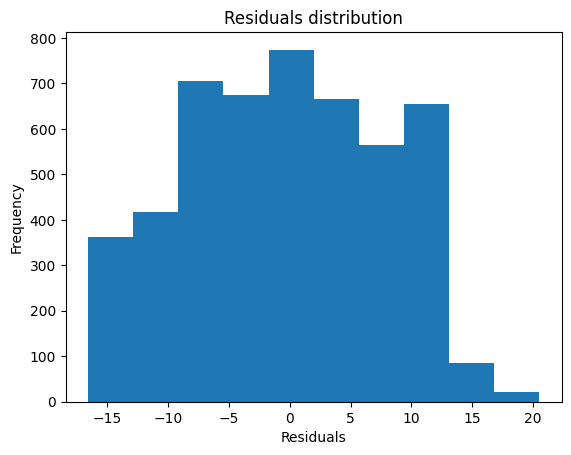

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


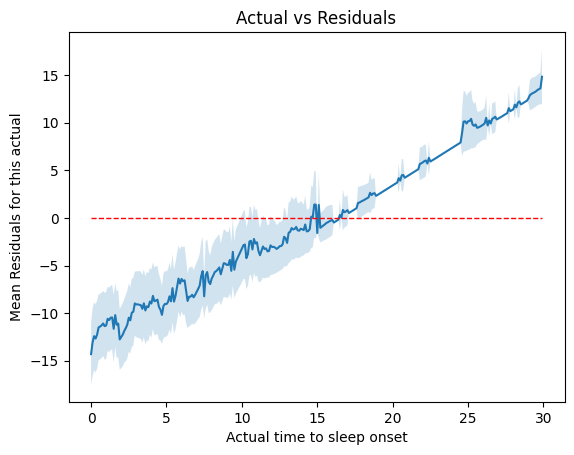

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


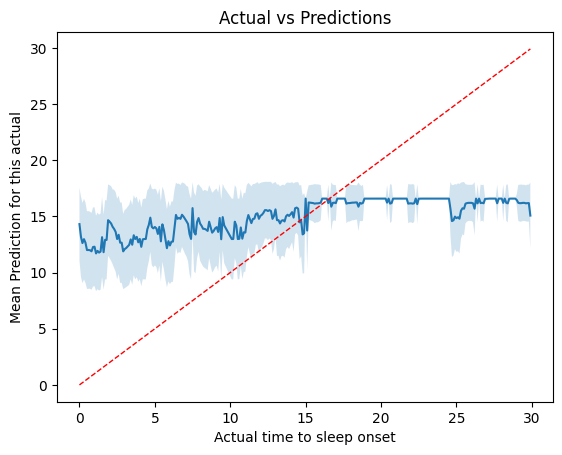

([49.230995178222656,
  50.58250427246094,
  21.177566528320312,
  31.542491912841797,
  37.8607063293457,
  37.82114028930664,
  44.41651153564453,
  32.984371185302734,
  53.816627502441406,
  45.83236312866211,
  32.034881591796875,
  14.434173583984375,
  12.347785949707031,
  57.65268325805664,
  39.01324462890625,
  56.45355987548828,
  26.611164093017578,
  38.74633026123047,
  15.658093452453613,
  32.711483001708984,
  30.503005981445312,
  28.11420249938965,
  41.087608337402344,
  26.850452423095703,
  41.63262939453125,
  19.714641571044922,
  33.196895599365234,
  41.714813232421875,
  31.181520462036133,
  16.5645809173584],
 [76.60709973956857,
  74.4305875703886,
  67.24449679603825,
  71.13666459569683,
  67.32849045620335,
  68.30354777946101,
  68.3134538330041,
  66.68837663995755,
  72.33644776723601,
  70.09871684072854,
  72.73143241235188,
  68.86638842929493,
  59.55073467361463,
  71.40949863079307,
  69.5064912728675,
  67.24227455219665,
  59.29853724194812,

In [36]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead= 4,
                                        num_layers = 2, num_epochs = 30, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None)

There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 27.572834014892578, Validation Loss: 73.5755071841277
Val Mean Squared Error: 73.56324768066406, Val R2 Score: 0.10576229909623103
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 55.39557647705078, Validation Loss: 73.38555692736205
Val Mean Squared Error: 73.39781951904297, Val R2 Score: 0.10777333728540794
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 12.535000801086426, Validation Loss: 64.55056865726199
Val Mean Squared Error: 64.55904388427734, Val R2 Score: 0.21521786530447784
Epoch 4/5
----------------------------------------------------------------------------------------------------
Ep

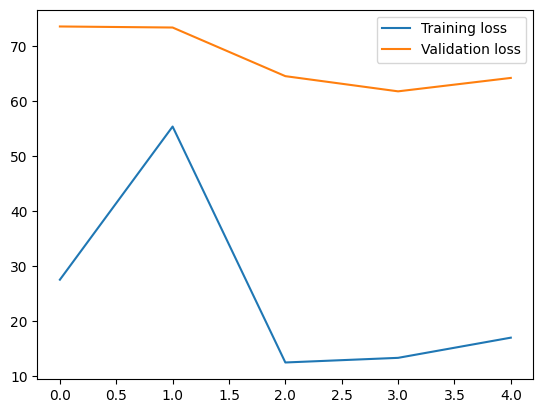

Test Loss: 64.22959595492908
Mean Squared Error: 64.23265
R2 Score: 0.21918543373353627
Mean Absolute Error: 6.668167
Test MSE: 64.23265
Test R2: 0.21918543373353627
Test MAE: 6.668167
Mean Absolute Error: 6.67
Accuracy: -inf %.
Mean Squared Error: 64.23
Root Mean Squared Error: 8.01
R2: 0.22


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


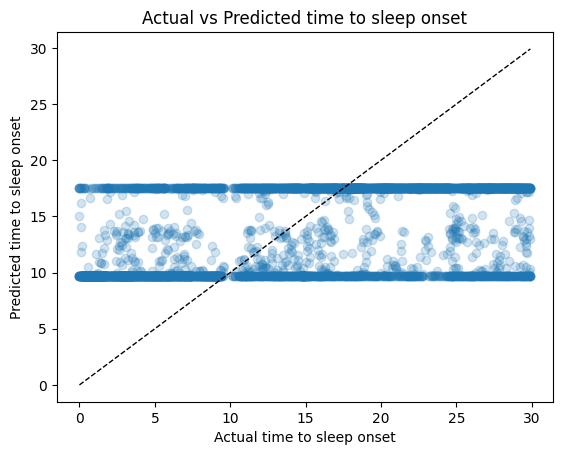

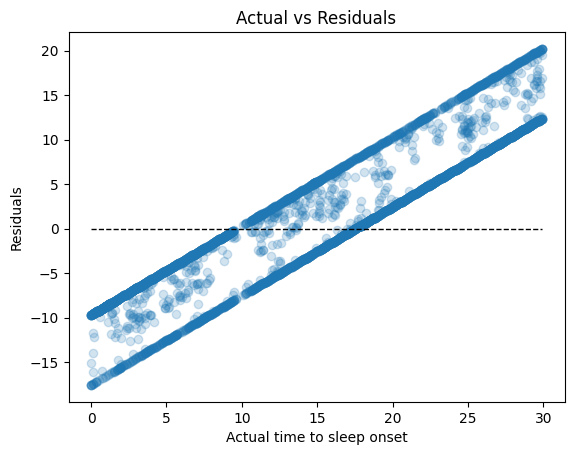

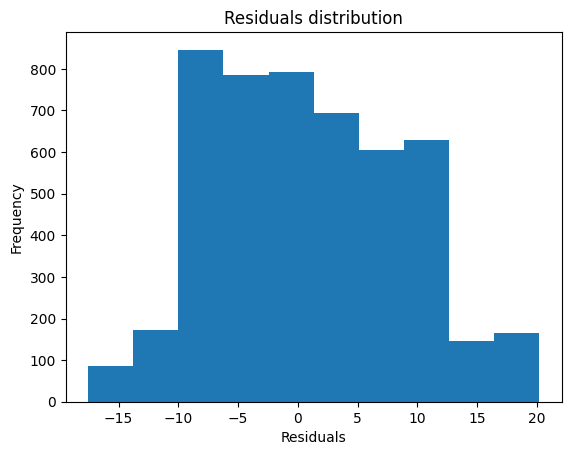

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


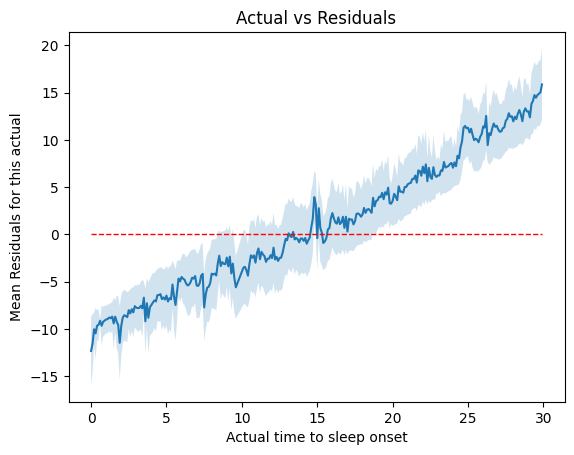

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


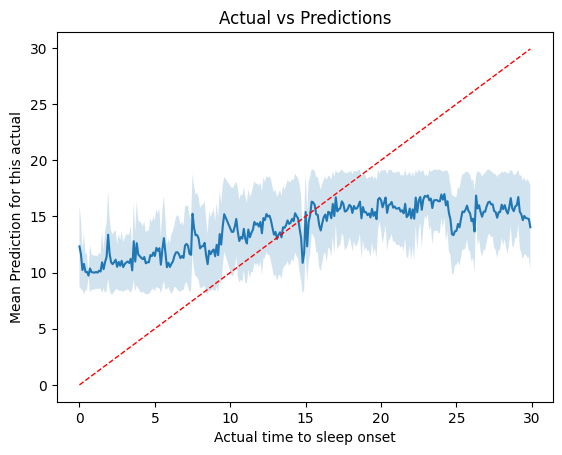

([27.572834014892578,
  55.39557647705078,
  12.535000801086426,
  13.376059532165527,
  17.04303741455078],
 [73.5755071841277,
  73.38555692736205,
  64.55056865726199,
  61.79172125052322,
  64.22959595492908],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
         )
         (linear1): Linear(in_features=512, out_features=2048, bias=True)
         (dropout): Dropout(p=0.0, inplace=False)
         (linear2): Linear(in_features=2048, out_features=512, bias=True)
         (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((512,), eps=1e-05, e

In [37]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead= 2,
                                        num_layers = 2, num_epochs = 5, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                         ifplot=True, ifsaveplots=True, output_path=None)

There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 16.283592224121094, Validation Loss: 70.4574775428741
Val Mean Squared Error: 70.4561538696289, Val R2 Score: 0.1435322717818781
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 28.954809188842773, Validation Loss: 65.6797965447624
Val Mean Squared Error: 65.6878433227539, Val R2 Score: 0.20149604727500492
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 44.55230712890625, Validation Loss: 73.95407712033817
Val Mean Squared Error: 73.96464538574219, Val R2 Score: 0.10088299636948117
Epoch 4/5
----------------------------------------------------------------------------------------------------
Epoch 

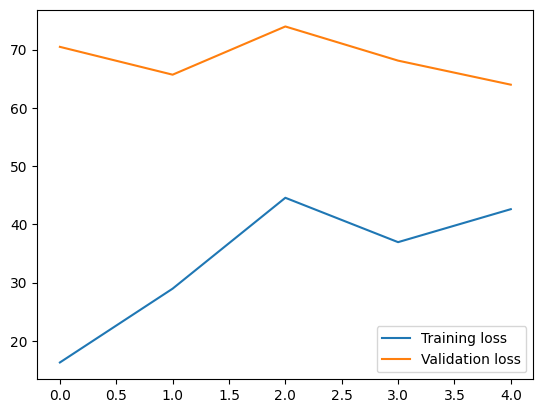

Test Loss: 63.96330270558209
Mean Squared Error: 63.965706
R2 Score: 0.22243051260882973
Mean Absolute Error: 6.7166924
Test MSE: 63.965706
Test R2: 0.22243051260882973
Test MAE: 6.7166924
Mean Absolute Error: 6.72
Accuracy: -inf %.
Mean Squared Error: 63.97
Root Mean Squared Error: 8.0
R2: 0.22


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


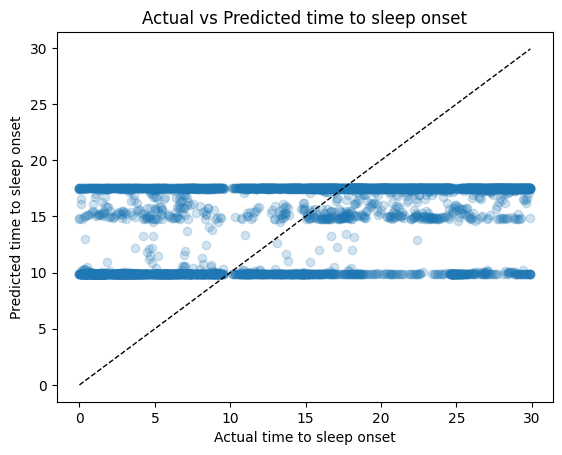

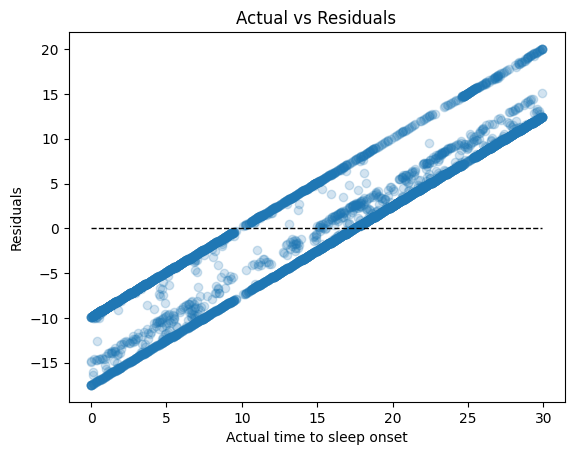

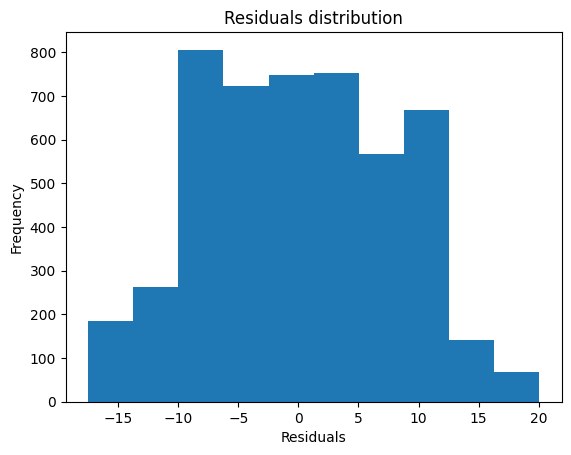

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


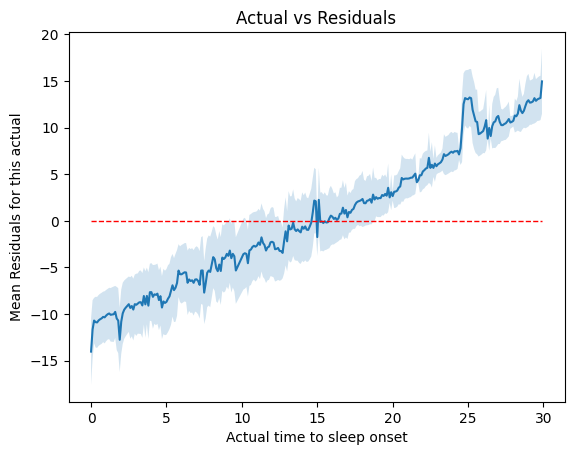

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


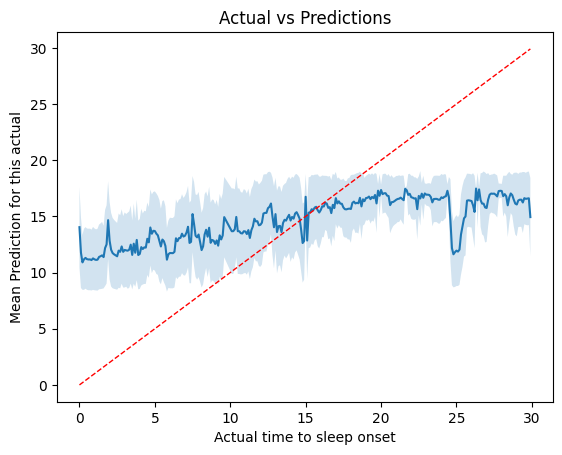

([16.283592224121094,
  28.954809188842773,
  44.55230712890625,
  36.93611526489258,
  42.59642791748047],
 [70.4574775428741,
  65.6797965447624,
  73.95407712033817,
  68.0926693720477,
  63.96330270558209],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
         )
         (linear1): Linear(in_features=512, out_features=2048, bias=True)
         (dropout): Dropout(p=0.0, inplace=False)
         (linear2): Linear(in_features=2048, out_features=512, bias=True)
         (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((512,), eps=1e-05, elem

In [38]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 2,
                                        num_layers = 2, num_epochs = 5, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                       ifplot=True, ifsaveplots=True, output_path=None)

There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 50.77852249145508, Validation Loss: 76.81746226800726
Val Mean Squared Error: 76.8221664428711, Val R2 Score: 0.06614677699616833
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 46.243682861328125, Validation Loss: 73.38383238694884
Val Mean Squared Error: 73.40035247802734, Val R2 Score: 0.1077424401830811
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 42.57518768310547, Validation Loss: 70.73938404120408
Val Mean Squared Error: 70.75587463378906, Val R2 Score: 0.13988884591589557
Epoch 4/5
----------------------------------------------------------------------------------------------------
Epoc

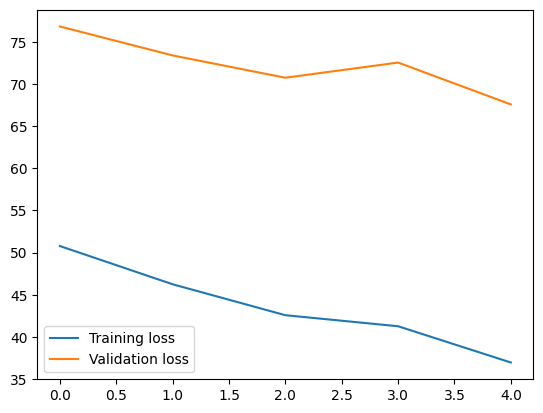

Test Loss: 67.5776421241946
Mean Squared Error: 67.59309
R2 Score: 0.1783358461675899
Mean Absolute Error: 6.8360643
Test MSE: 67.59309
Test R2: 0.1783358461675899
Test MAE: 6.8360643
Mean Absolute Error: 6.84
Accuracy: -inf %.
Mean Squared Error: 67.59
Root Mean Squared Error: 8.22
R2: 0.18


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


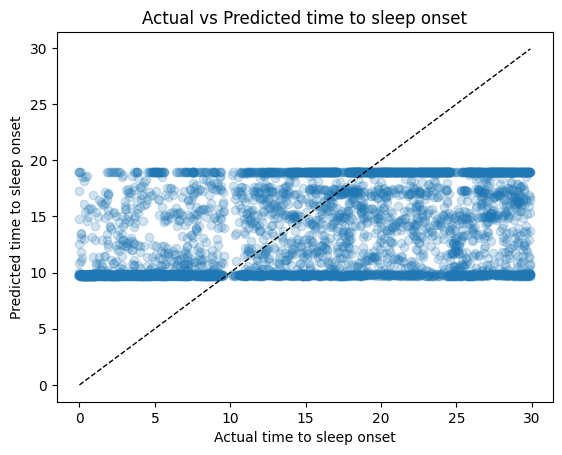

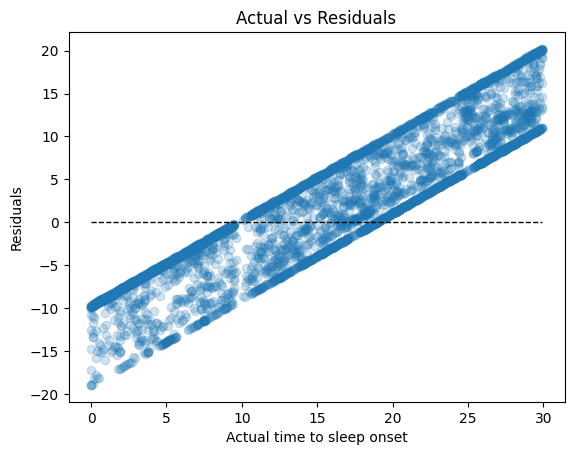

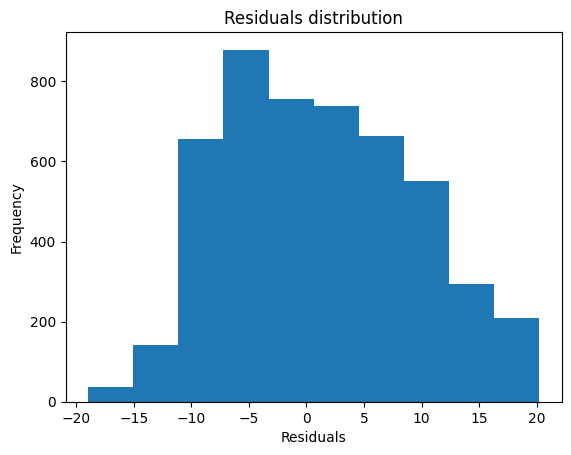

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


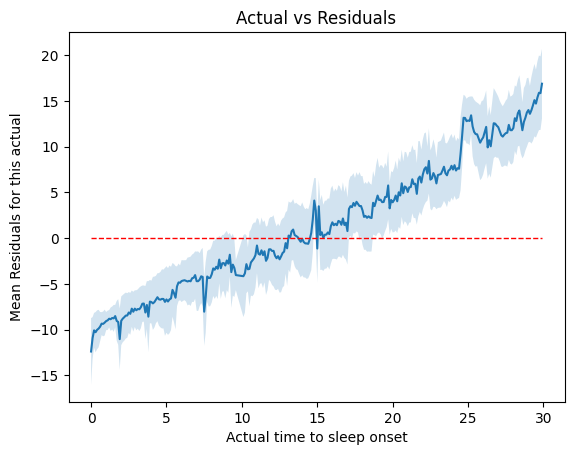

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


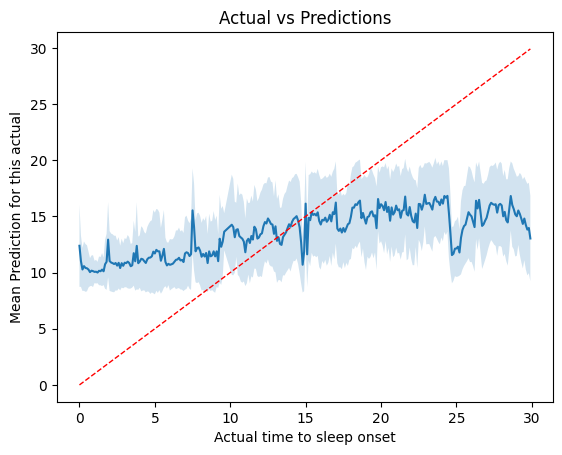

([50.77852249145508,
  46.243682861328125,
  42.57518768310547,
  41.26628494262695,
  36.96910095214844],
 [76.81746226800726,
  73.38383238694884,
  70.73938404120408,
  72.53873404937904,
  67.5776421241946],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
         )
         (linear1): Linear(in_features=512, out_features=2048, bias=True)
         (dropout): Dropout(p=0.0, inplace=False)
         (linear2): Linear(in_features=2048, out_features=512, bias=True)
         (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((512,), eps=1e-05, ele

In [39]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 5, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 16, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                       ifplot=True, ifsaveplots=True, output_path=None)

## Try on last 5 minutes of the clean onset

In [40]:
data_clean_5 = data_clean_onset[data_clean_onset['Label'] <= 5].copy()

In [41]:
data_clean_5

Label  Sbj_ID  Age  Gender  Race1  Race2  Race3  Race4  ifCleanOnset  \
249      5.0      12   80       1    1.0    0.0    0.0    0.0             1   
250      4.9      12   80       1    1.0    0.0    0.0    0.0             1   
251      4.8      12   80       1    1.0    0.0    0.0    0.0             1   
252      4.7      12   80       1    1.0    0.0    0.0    0.0             1   
253      4.6      12   80       1    1.0    0.0    0.0    0.0             1   
...      ...     ...  ...     ...    ...    ...    ...    ...           ...   
92695    0.4    6790   72       1    1.0    0.0    0.0    0.0             1   
92696    0.3    6790   72       1    1.0    0.0    0.0    0.0             1   
92697    0.2    6790   72       1    1.0    0.0    0.0    0.0             1   
92698    0.1    6790   72       1    1.0    0.0    0.0    0.0             1   
92699    0.0    6790   72       1    1.0    0.0    0.0    0.0             1   

       Time2Sleep  ...  wrseltr5  slpapnea5  cpap5  dntaldv5  uvula5  \
249          66.0  ...       9.0        0.0    0.0       0.0     0.0   
250          66.0  ...       9.0        0.0    0.0       0.0     0.0   
251          66.0  ...       9.0        0.0    0.0       0.0     0.0   
252          66.0  ...       9.0        0.0    0.0       0.0     0.0   
253          66.0  ...       9.0        0.0    0.0       0.0     0.0   
...           ...  ...       ...        ...    ...       ...     ...   
92695        57.0  ...      -1.0        0.0    0.0       0.0     0.0   
92696        57.0  ...      -1.0        0.0    0.0       0.0     0.0   
92697        57.0  ...      -1.0        0.0    0.0       0.0     0.0   
92698        57.0  ...      -1.0        0.0    0.0       0.0     0.0   
92699        57.0  ...      -1.0        0.0    0.0       0.0     0.0   

       insmnia5  rstlesslgs5  whiirs5c  epslpscl5c  hoostmeq5c  
249         0.0          0.0       9.0         5.0        12.0  
250         0.0          0.0       9.0         5.0        12.0  
251         0.0          0.0       9.0         5.0        12.0  
252         0.0          0.0       9.0         5.0        12.0  
253         0.0          0.0       9.0         5.0        12.0  
...         ...          ...       ...         ...         ...  
92695       0.0          0.0      13.0        11.0        15.0  
92696       0.0          0.0      13.0        11.0        15.0  
92697       0.0          0.0      13.0        11.0        15.0  
92698       0.0          0.0      13.0        11.0        15.0  
92699       0.0          0.0      13.0        11.0        15.0  

[15759 rows x 90 columns]

There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/15
----------------------------------------------------------------------------------------------------
Epoch 1/15, Loss: 5.184719562530518, Validation Loss: 2.303208076953888
Val Mean Squared Error: 2.3129689693450928, Val R2 Score: 0.13100036856338315
Epoch 2/15
----------------------------------------------------------------------------------------------------
Epoch 2/15, Loss: 3.076770782470703, Validation Loss: 1.9375247518221537
Val Mean Squared Error: 1.9362133741378784, Val R2 Score: 0.2725502740778407
Epoch 3/15
----------------------------------------------------------------------------------------------------
Epoch 3/15, Loss: 2.742187738418579, Validation Loss: 1.8920497874418893
Val Mean Squared Error: 1.8894679546356201, Val R2 Score: 0.2901127999078831
Epoch 4/15
----------------------------------------------------------------------------------------------

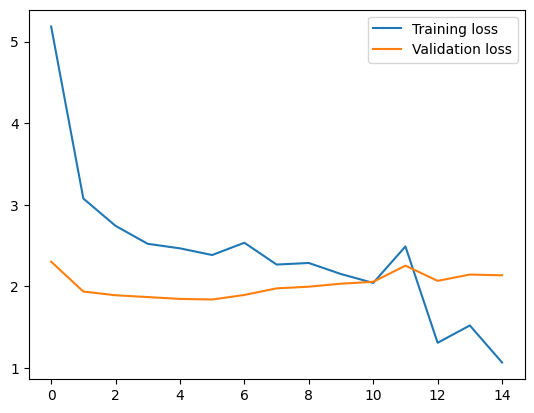

Test Loss: 2.1364214877287546
Mean Squared Error: 2.1429799
R2 Score: 0.19486645181154283
Mean Absolute Error: 1.1554012
Test MSE: 2.1429799
Test R2: 0.19486645181154283
Test MAE: 1.1554012
Mean Absolute Error: 1.16
Accuracy: -inf %.
Mean Squared Error: 2.14
Root Mean Squared Error: 1.46
R2: 0.19


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


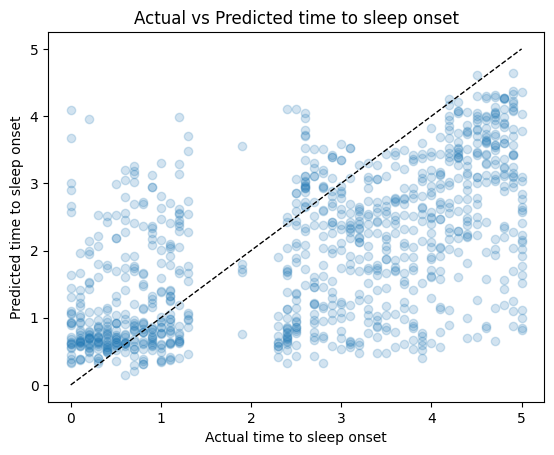

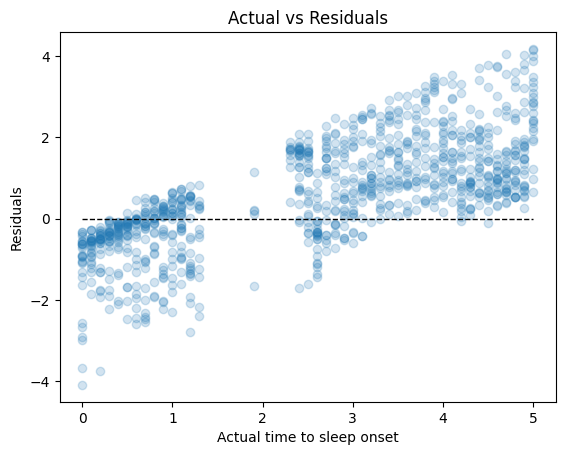

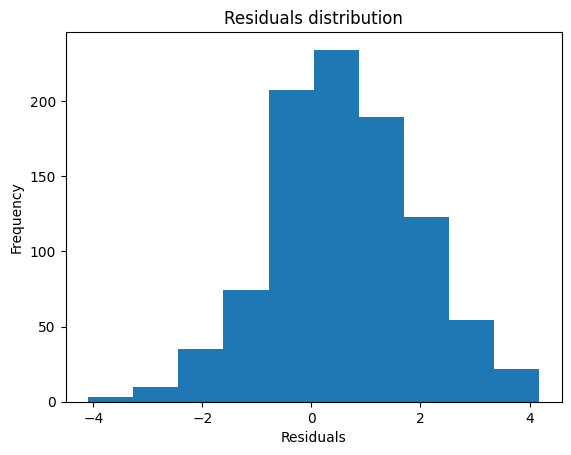

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


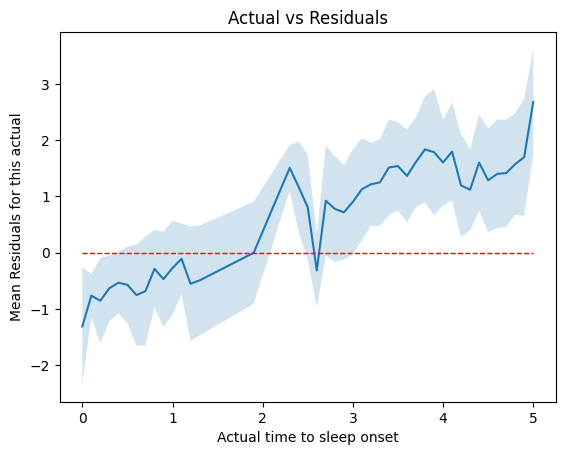

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


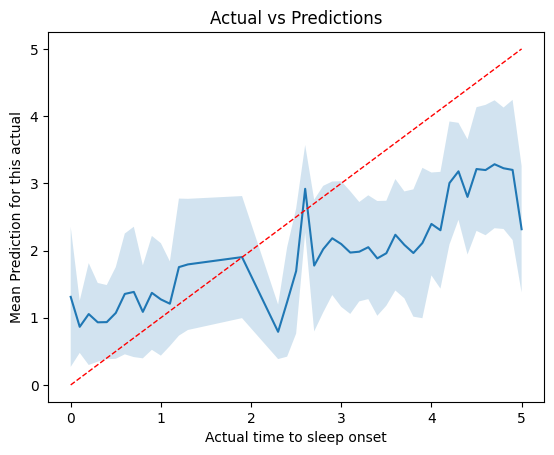

([5.184719562530518,
  3.076770782470703,
  2.742187738418579,
  2.522145986557007,
  2.466628313064575,
  2.384829521179199,
  2.5352697372436523,
  2.268315315246582,
  2.2873475551605225,
  2.1519229412078857,
  2.043164014816284,
  2.48976469039917,
  1.3097318410873413,
  1.5221370458602905,
  1.0685293674468994],
 [2.303208076953888,
  1.9375247518221537,
  1.8920497874418893,
  1.8697708090146383,
  1.847320415576299,
  1.8398086150487265,
  1.8957669297854105,
  1.976439102490743,
  1.9970920483271282,
  2.033819439013799,
  2.056835651397705,
  2.2548459748427074,
  2.0685951968034106,
  2.145767734448115,
  2.1364214877287546],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention

In [42]:
training_loop_feature_RNN_regression(data_clean_5, filling_limit = 0, method = None, input_size = 86,
                                    num_epochs = 15,  nhead = 2, num_layers = 2,
                                    l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 32, device = device, 
                                    random_seed=42, window_size_minutes=1, 
                                    iftest=False, ifoutputpredictions=0, 
                                    ifplot=True, ifsaveplots=True, output_path=None)

## Try to create a custom loss function

In [43]:
import torch
import torch.nn as nn

class CustomMSELoss(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(CustomMSELoss, self).__init__()
        self.epsilon = epsilon  # Small value to prevent division by zero

    def forward(self, predictions, targets):
        # Compute error
        errors = (predictions - targets)**2

        # Compute weights inversely proportional to target values
        weights = 1.0 / (torch.abs(targets) + self.epsilon)

        # Weighted sum of errors
        loss = torch.sum(weights * errors) / torch.sum(weights)
        return loss

# Test the custom loss
predictions = torch.tensor([0.5, 0.2, 0.7])
targets = torch.tensor([0.1, 0.4, 0.8])
criterion = CustomMSELoss()
loss = criterion(predictions, targets)
print(loss)


tensor(0.1245)


There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/5
----------------------------------------------------------------------------------------------------
Epoch 1/5, Loss: 155.38880920410156, Validation Loss: 72.79577916628355
Val Mean Squared Error: 106.1695556640625, Val R2 Score: -0.2906011720179722
Epoch 2/5
----------------------------------------------------------------------------------------------------
Epoch 2/5, Loss: 164.44227600097656, Validation Loss: 70.126558824019
Val Mean Squared Error: 104.89686584472656, Val R2 Score: -0.27513027517334754
Epoch 3/5
----------------------------------------------------------------------------------------------------
Epoch 3/5, Loss: 177.75888061523438, Validation Loss: 71.7484770440436
Val Mean Squared Error: 111.57152557373047, Val R2 Score: -0.3562676624406096
Epoch 4/5
----------------------------------------------------------------------------------------------------


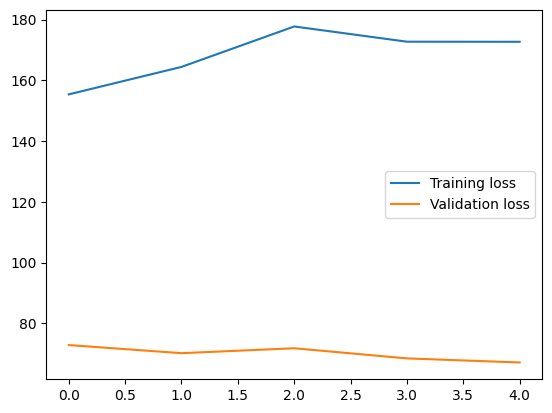

Test Loss: 67.06254915757613
Mean Squared Error: 98.311676
R2 Score: -0.19508040582335084
Mean Absolute Error: 7.813809
Test MSE: 98.311676
Test R2: -0.19508040582335084
Test MAE: 7.813809
Mean Absolute Error: 7.81
Accuracy: -inf %.
Mean Squared Error: 98.31
Root Mean Squared Error: 9.92
R2: -0.2


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


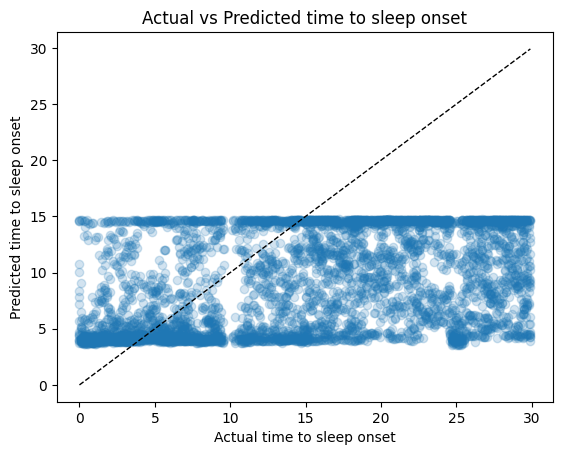

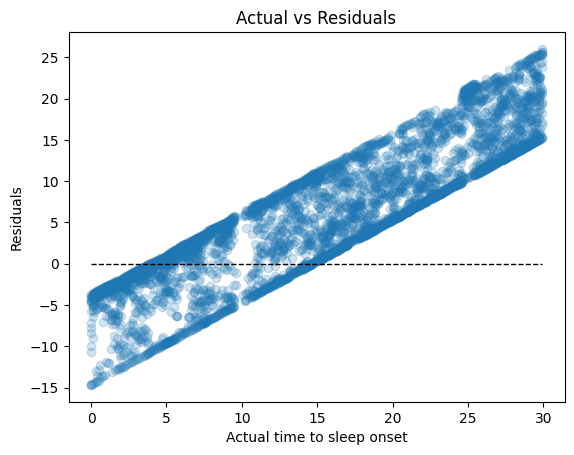

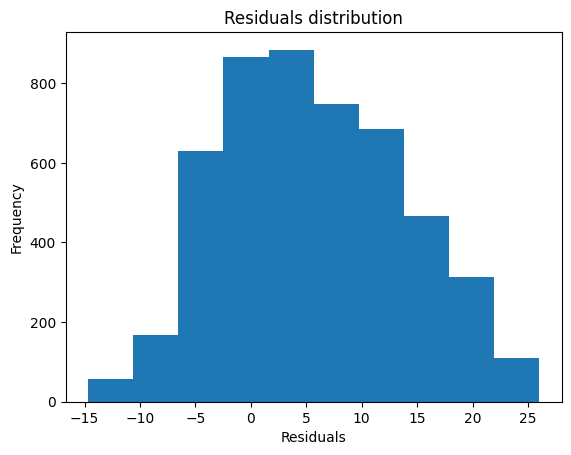

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


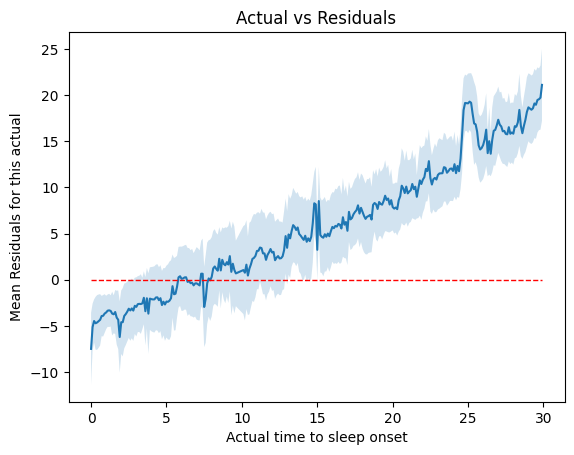

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


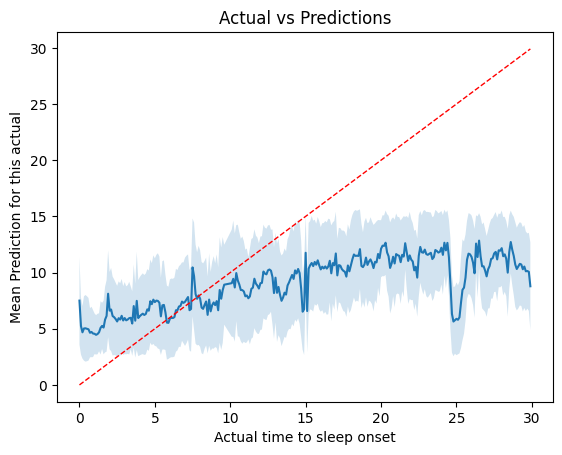

([155.38880920410156,
  164.44227600097656,
  177.75888061523438,
  172.74610900878906,
  172.71490478515625],
 [72.79577916628355,
  70.126558824019,
  71.7484770440436,
  68.402279209781,
  67.06254915757613],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
         )
         (linear1): Linear(in_features=512, out_features=2048, bias=True)
         (dropout): Dropout(p=0.0, inplace=False)
         (linear2): Linear(in_features=2048, out_features=512, bias=True)
         (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((512,), eps=1e-05, ele

In [44]:
prioritize_onset_loss = CustomMSELoss()
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 5, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 64, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                         ifplot=True, ifsaveplots=True, output_path=None, loss_function=prioritize_onset_loss)

There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/15
----------------------------------------------------------------------------------------------------
Epoch 1/15, Loss: 156.43421936035156, Validation Loss: 65.80737920240922
Val Mean Squared Error: 99.17036437988281, Val R2 Score: -0.20551868526338857
Epoch 2/15
----------------------------------------------------------------------------------------------------
Epoch 2/15, Loss: 159.6766815185547, Validation Loss: 64.3024665782978
Val Mean Squared Error: 98.48663330078125, Val R2 Score: -0.19720733329758988
Epoch 3/15
----------------------------------------------------------------------------------------------------
Epoch 3/15, Loss: 135.96401977539062, Validation Loss: 60.919342078171766
Val Mean Squared Error: 85.8995590209961, Val R2 Score: -0.0441983017680212
Epoch 4/15
----------------------------------------------------------------------------------------------

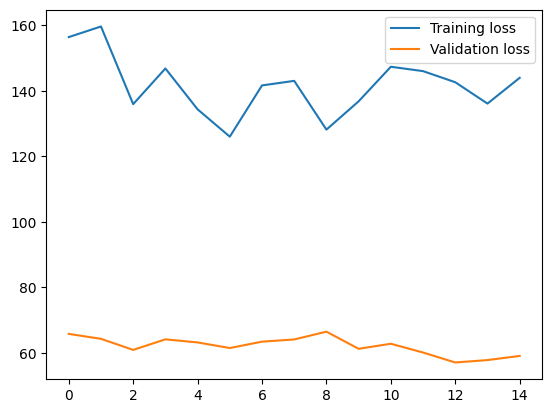

Test Loss: 59.077612443403765
Mean Squared Error: 86.729965
R2 Score: -0.054292640843377926
Mean Absolute Error: 7.1036534
Test MSE: 86.729965
Test R2: -0.054292640843377926
Test MAE: 7.1036534
Mean Absolute Error: 7.1
Accuracy: -inf %.
Mean Squared Error: 86.73
Root Mean Squared Error: 9.31
R2: -0.05


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


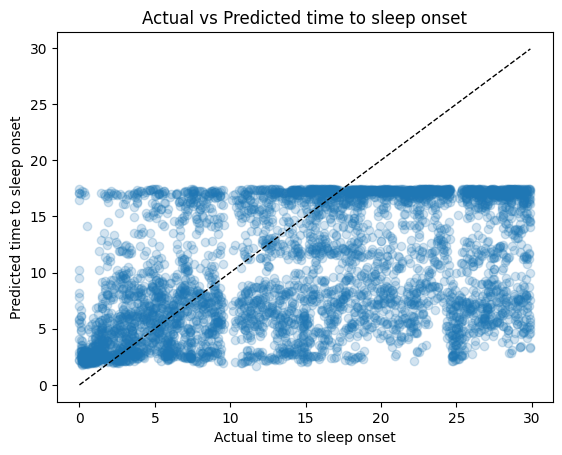

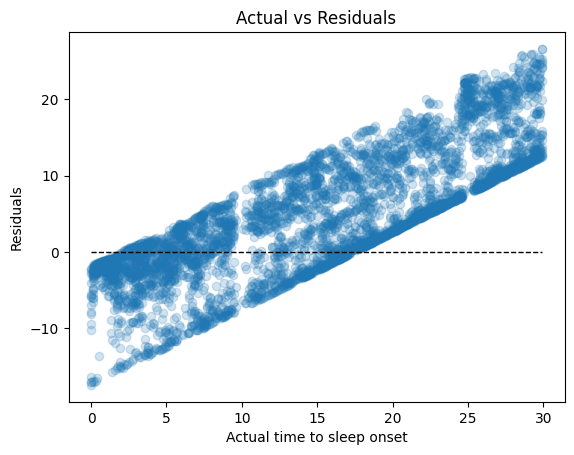

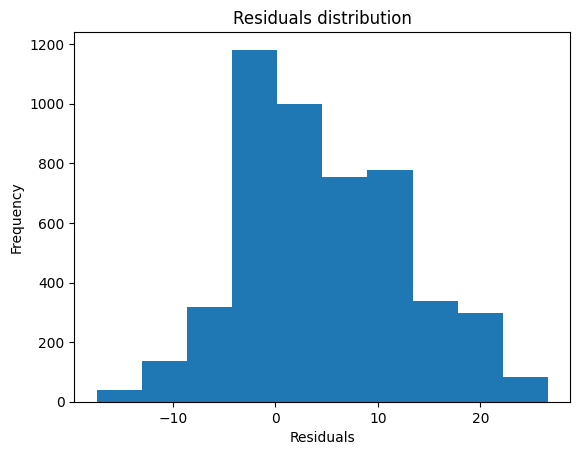

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


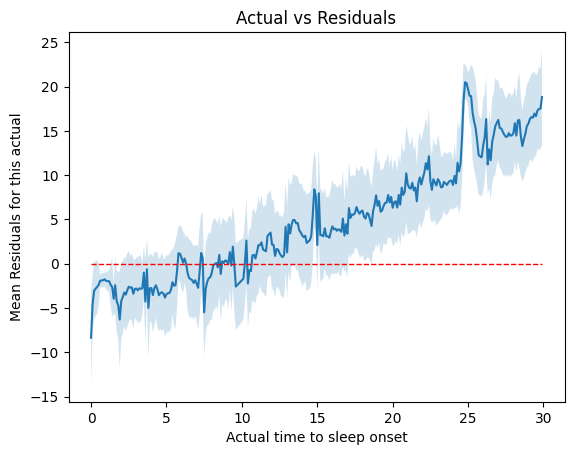

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


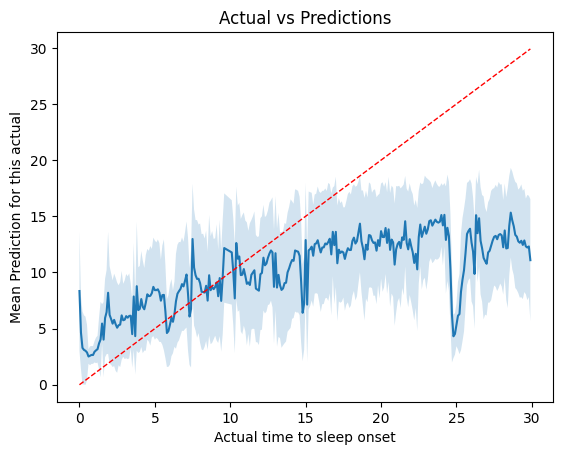

([156.43421936035156,
  159.6766815185547,
  135.96401977539062,
  146.85223388671875,
  134.37965393066406,
  126.03076934814453,
  141.67872619628906,
  143.06895446777344,
  128.18544006347656,
  136.82786560058594,
  147.37847900390625,
  146.04251098632812,
  142.65406799316406,
  136.13192749023438,
  143.99688720703125],
 [65.80737920240922,
  64.3024665782978,
  60.919342078171766,
  64.14532423638678,
  63.19900563475373,
  61.492824938390164,
  63.43571430057674,
  64.1083788933692,
  66.48430294185489,
  61.26174129758562,
  62.796841992960346,
  60.12053448194033,
  57.07934063750428,
  57.81186292078588,
  59.077612443403765],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttenti

In [45]:
prioritize_onset_loss = CustomMSELoss(epsilon=0.1)
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 15, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 64, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None, loss_function=prioritize_onset_loss)

There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/15
----------------------------------------------------------------------------------------------------
Epoch 1/15, Loss: 105.5225830078125, Validation Loss: 51.01843009850918
Val Mean Squared Error: 119.25971984863281, Val R2 Score: -0.4497256639433038
Epoch 2/15
----------------------------------------------------------------------------------------------------
Epoch 2/15, Loss: 100.27941131591797, Validation Loss: 49.622610312241775
Val Mean Squared Error: 115.39474487304688, Val R2 Score: -0.4027430279533222
Epoch 3/15
----------------------------------------------------------------------------------------------------
Epoch 3/15, Loss: 101.12248229980469, Validation Loss: 50.14354409926977
Val Mean Squared Error: 115.93246459960938, Val R2 Score: -0.4092794478874504
Epoch 4/15
-------------------------------------------------------------------------------------------

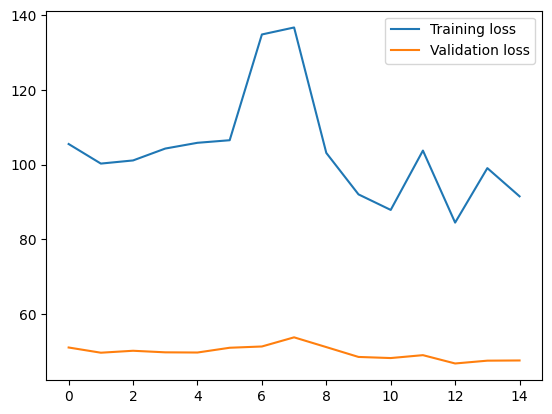

Test Loss: 47.54451336004795
Mean Squared Error: 100.257904
R2 Score: -0.21873888492441607
Mean Absolute Error: 7.7152967
Test MSE: 100.257904
Test R2: -0.21873888492441607
Test MAE: 7.7152967
Mean Absolute Error: 7.72
Accuracy: -inf %.
Mean Squared Error: 100.26
Root Mean Squared Error: 10.01
R2: -0.22


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


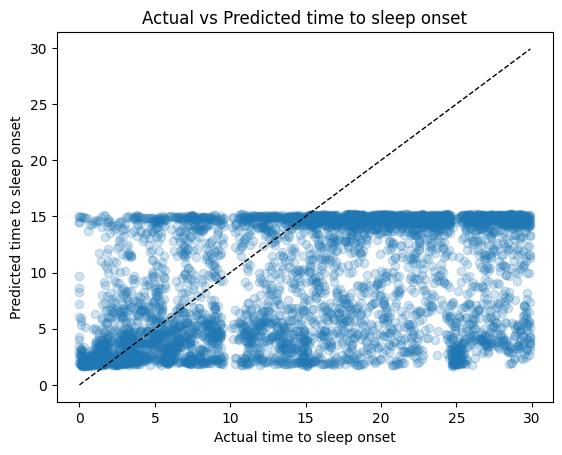

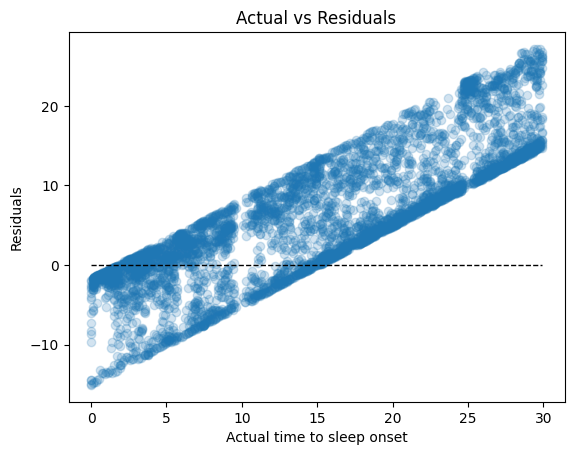

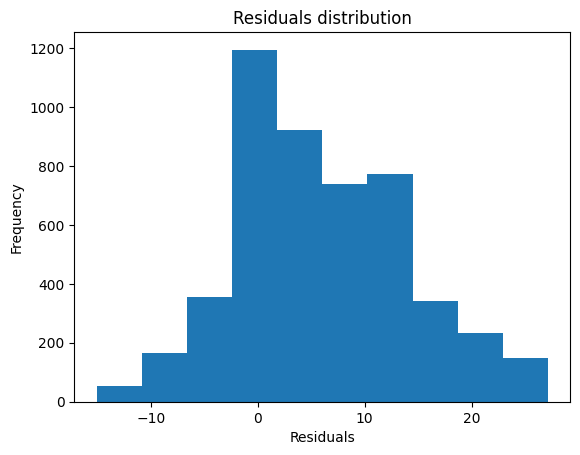

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


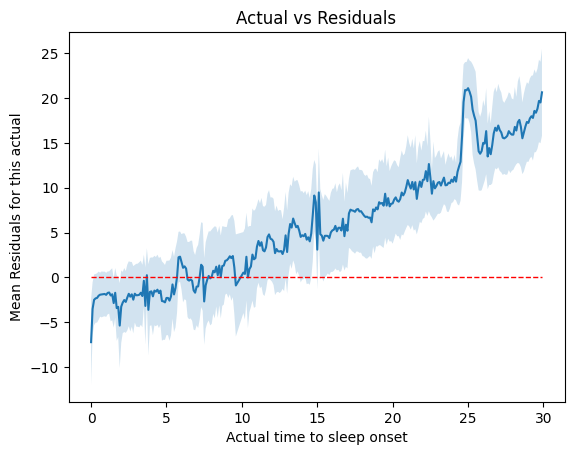

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


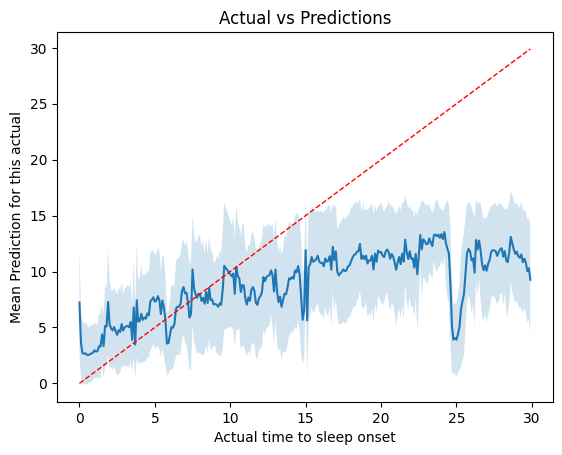

([105.5225830078125,
  100.27941131591797,
  101.12248229980469,
  104.30509948730469,
  105.8478012084961,
  106.53614044189453,
  134.8636016845703,
  136.73648071289062,
  103.1341323852539,
  92.02786254882812,
  87.86563110351562,
  103.76519775390625,
  84.47066497802734,
  99.06294250488281,
  91.50843811035156],
 [51.01843009850918,
  49.622610312241775,
  50.14354409926977,
  49.7243465032333,
  49.6735853537535,
  50.95050278688088,
  51.28877869630471,
  53.741238373976486,
  51.12578130379701,
  48.487769371423965,
  48.19116254953238,
  48.96773135356414,
  46.73884915082883,
  47.49168887505164,
  47.54451336004795],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
     

In [46]:
prioritize_onset_loss = CustomMSELoss(epsilon=0.1)
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 15, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None, loss_function=prioritize_onset_loss)

## Another Custom loss, which is even more weighted towards the smaller values

In [47]:
import torch
import torch.nn as nn

class CustomMSELossSquared(nn.Module):
    def __init__(self, epsilon=1e-6):
        super(CustomMSELossSquared, self).__init__()
        self.epsilon = epsilon  # Small value to prevent division by zero

    def forward(self, predictions, targets):
        # Compute error
        errors = (predictions - targets)**2

        # Compute weights inversely proportional to target values
        weights = 1.0 / (torch.abs(targets) + self.epsilon)**2

        # Weighted sum of errors
        loss = torch.sum(weights * errors) / torch.sum(weights)
        return loss

# Test the custom loss
predictions = torch.tensor([0.5, 0.2, 0.7])
targets = torch.tensor([0.1, 0.4, 0.8])
criterion = CustomMSELossSquared()
loss = criterion(predictions, targets)
print(loss)


tensor(0.1509)


There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/16
----------------------------------------------------------------------------------------------------
Epoch 1/16, Loss: 107.80738830566406, Validation Loss: 27.899706161939182
Val Mean Squared Error: 200.41744995117188, Val R2 Score: -1.4362821410852469
Epoch 2/16
----------------------------------------------------------------------------------------------------
Epoch 2/16, Loss: 119.08878326416016, Validation Loss: 27.77737314884479
Val Mean Squared Error: 206.55047607421875, Val R2 Score: -1.5108355433087954
Epoch 3/16
----------------------------------------------------------------------------------------------------
Epoch 3/16, Loss: 110.12431335449219, Validation Loss: 28.021104268538647
Val Mean Squared Error: 199.74661254882812, Val R2 Score: -1.4281274520790825
Epoch 4/16
-----------------------------------------------------------------------------------------

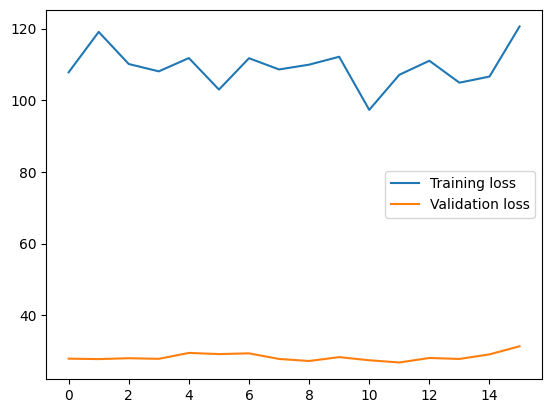

Test Loss: 31.350650212703606
Mean Squared Error: 213.63599
R2 Score: -1.596967316687548
Mean Absolute Error: 11.920307
Test MSE: 213.63599
Test R2: -1.596967316687548
Test MAE: 11.920307
Mean Absolute Error: 11.92
Accuracy: -inf %.
Mean Squared Error: 213.64
Root Mean Squared Error: 14.62
R2: -1.6


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


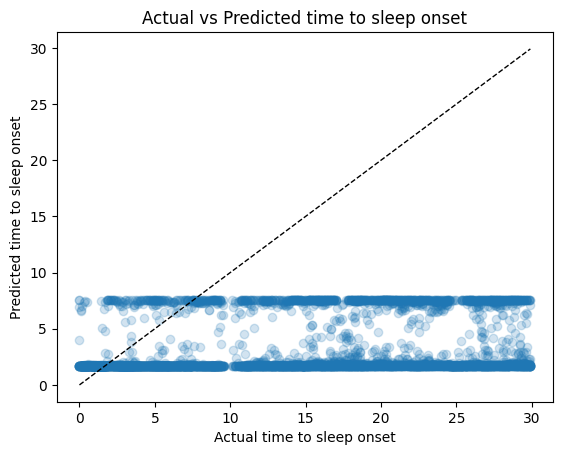

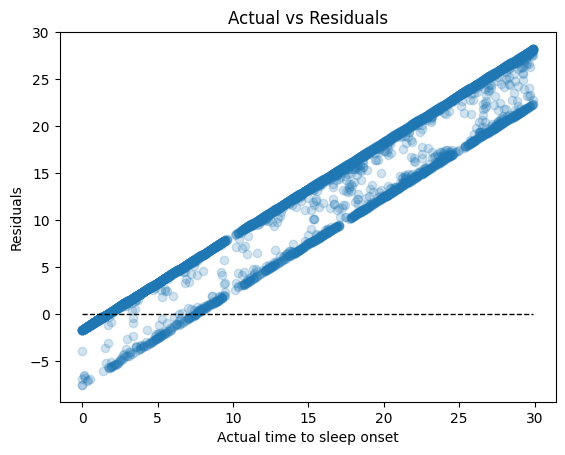

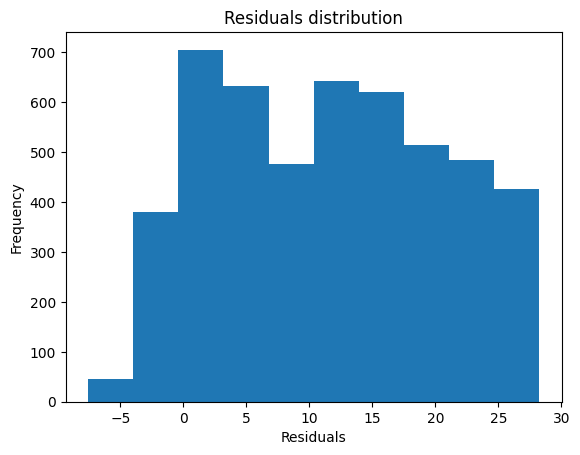

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


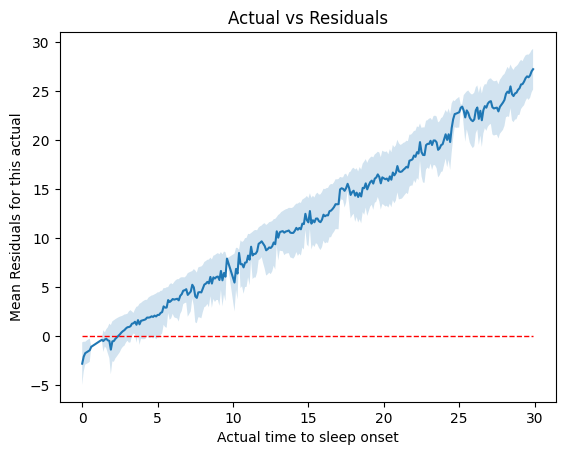

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


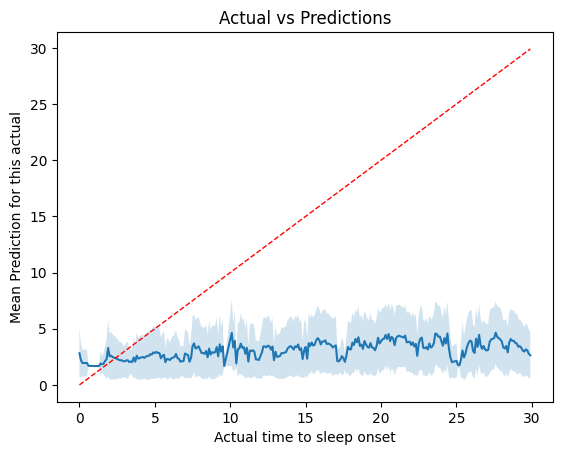

([107.80738830566406,
  119.08878326416016,
  110.12431335449219,
  108.07804870605469,
  111.79076385498047,
  102.99247741699219,
  111.74280548095703,
  108.6112289428711,
  109.94705963134766,
  112.1544189453125,
  97.33128356933594,
  107.12130737304688,
  111.03949737548828,
  104.91486358642578,
  106.62552642822266,
  120.60238647460938],
 [27.899706161939182,
  27.77737314884479,
  28.021104268538647,
  27.85132332642873,
  29.502578393006935,
  29.176334148798233,
  29.379906678811096,
  27.81359825990139,
  27.245948125154545,
  28.329736024905475,
  27.447003609094864,
  26.832613309224445,
  28.090144499754295,
  27.82128485655173,
  29.09407308774117,
  31.350650212703606],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEn

In [48]:

training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 16, l2 = 0, lr = 0.0001, weight_decay =0.5, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=1, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELossSquared())

There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/16
----------------------------------------------------------------------------------------------------
Epoch 1/16, Loss: 5.81450891494751, Validation Loss: 37.523616552352905
Val Mean Squared Error: 263.6559143066406, Val R2 Score: -2.087656613929729
Epoch 2/16
----------------------------------------------------------------------------------------------------
Epoch 2/16, Loss: 6.311514854431152, Validation Loss: 35.67017092023577
Val Mean Squared Error: 248.75376892089844, Val R2 Score: -1.9131386132673542
Epoch 3/16
----------------------------------------------------------------------------------------------------
Epoch 3/16, Loss: 5.761802673339844, Validation Loss: 33.598799543721334
Val Mean Squared Error: 236.19869995117188, Val R2 Score: -1.7661069241609497
Epoch 4/16
-----------------------------------------------------------------------------------------------

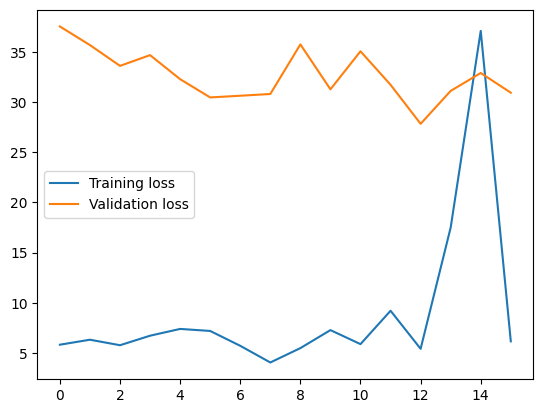

Test Loss: 30.924792346500215
Mean Squared Error: 195.63477
R2 Score: -1.2910655634994392
Mean Absolute Error: 11.558464
Test MSE: 195.63477
Test R2: -1.2910655634994392
Test MAE: 11.558464
Mean Absolute Error: 11.56
Accuracy: -inf %.
Mean Squared Error: 195.63
Root Mean Squared Error: 13.99
R2: -1.29


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


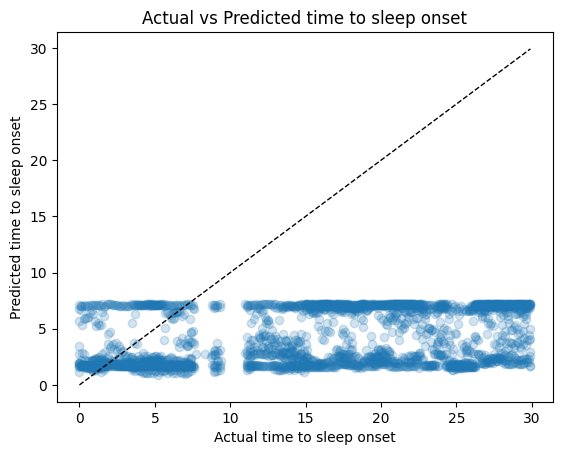

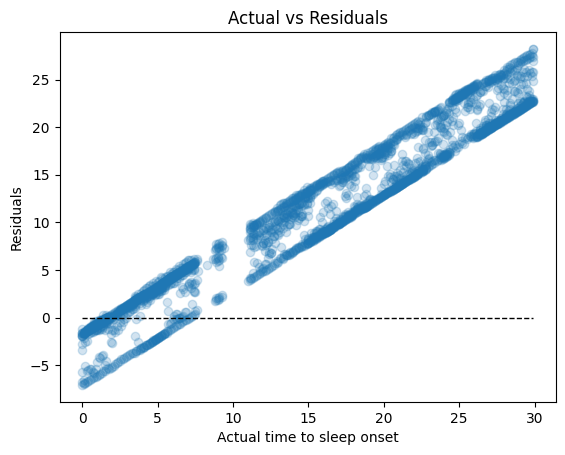

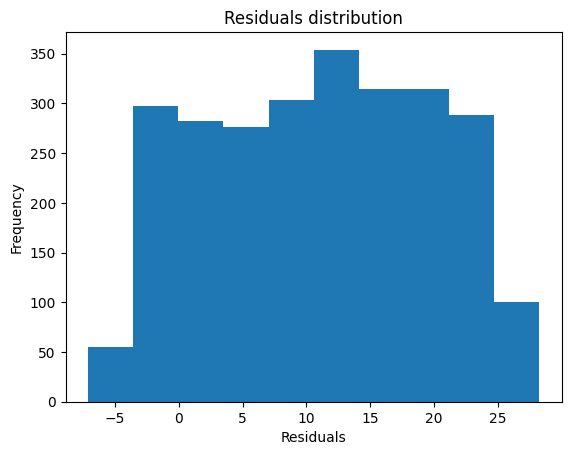

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


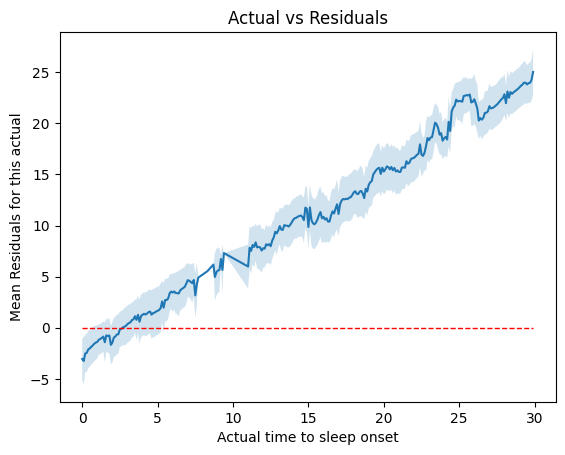

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


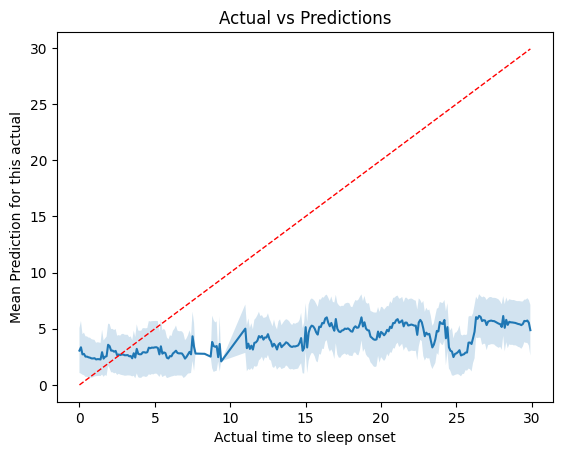

([5.81450891494751,
  6.311514854431152,
  5.761802673339844,
  6.711174011230469,
  7.386054515838623,
  7.1843743324279785,
  5.702877044677734,
  4.042954921722412,
  5.474132061004639,
  7.268835544586182,
  5.87134313583374,
  9.198238372802734,
  5.403774261474609,
  17.490875244140625,
  37.08403396606445,
  6.149070739746094],
 [37.523616552352905,
  35.67017092023577,
  33.598799543721334,
  34.66907276426043,
  32.27182625872748,
  30.453887141886213,
  30.622108550298783,
  30.796213967459543,
  35.736735809417,
  31.260907871382578,
  35.05295475323995,
  31.713884234428406,
  27.824866130238487,
  31.106408028375533,
  32.888808463300975,
  30.924792346500215],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
   

In [49]:

training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 16, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=3, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELossSquared())

There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/15
----------------------------------------------------------------------------------------------------
Epoch 1/15, Loss: 72.15457916259766, Validation Loss: 69.52481142679851
Val Mean Squared Error: 216.19009399414062, Val R2 Score: -1.5317874915731013
Epoch 2/15
----------------------------------------------------------------------------------------------------
Epoch 2/15, Loss: 69.861328125, Validation Loss: 68.51390920366559
Val Mean Squared Error: 207.16738891601562, Val R2 Score: -1.4261232862425222
Epoch 3/15
----------------------------------------------------------------------------------------------------
Epoch 3/15, Loss: 69.10810852050781, Validation Loss: 68.16533243088494
Val Mean Squared Error: 203.2264862060547, Val R2 Score: -1.3799716223394753
Epoch 4/15
----------------------------------------------------------------------------------------------------

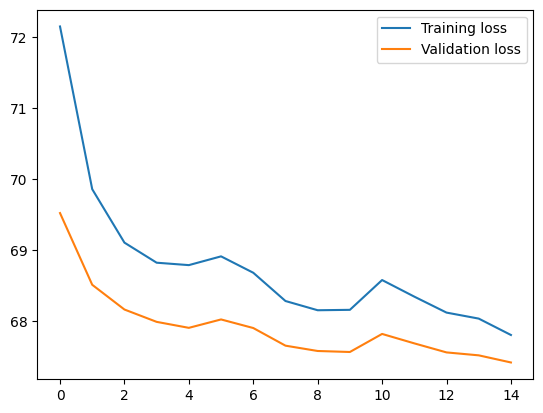

Test Loss: 67.41888291495187
Mean Squared Error: 188.08942
R2 Score: -1.2027023968793409
Mean Absolute Error: 11.250544
Test MSE: 188.08942
Test R2: -1.2027023968793409
Test MAE: 11.250544
Mean Absolute Error: 11.25
Accuracy: -inf %.
Mean Squared Error: 188.09
Root Mean Squared Error: 13.71
R2: -1.2


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


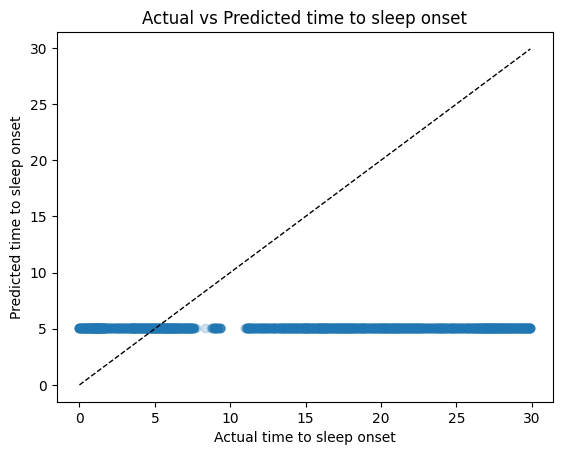

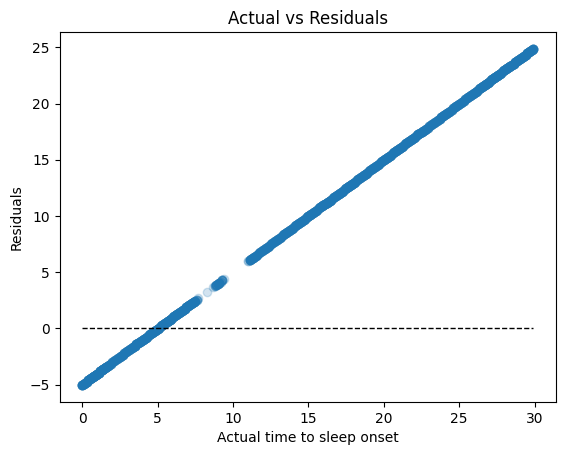

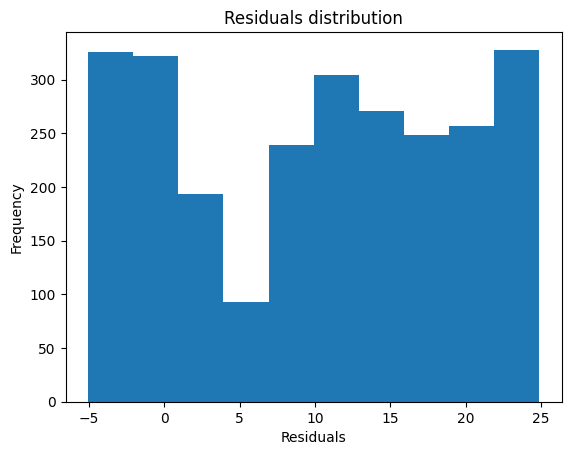

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


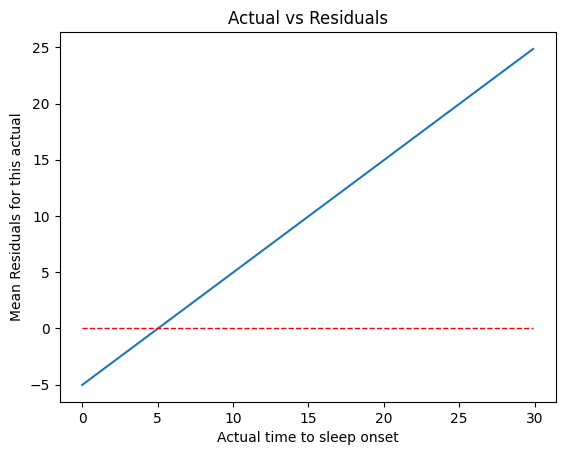

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


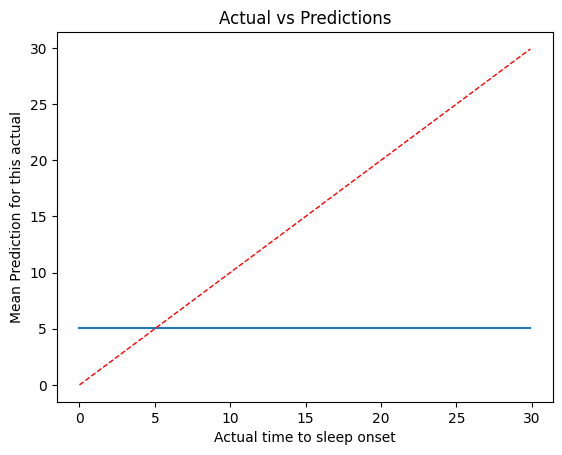

([72.15457916259766,
  69.861328125,
  69.10810852050781,
  68.82511138916016,
  68.79104614257812,
  68.91458129882812,
  68.68350982666016,
  68.28515625,
  68.15504455566406,
  68.16081237792969,
  68.58080291748047,
  68.3469009399414,
  68.1219482421875,
  68.03734588623047,
  67.80644226074219],
 [69.52481142679851,
  68.51390920366559,
  68.16533243088494,
  67.99133427937825,
  67.9070196605864,
  68.02545665559315,
  67.90453047979446,
  67.65588796706427,
  67.58075096493675,
  67.56670352390834,
  67.82119496663411,
  67.6882138025193,
  67.56077675592331,
  67.51944896153041,
  67.41888291495187],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonD

In [50]:

training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 15, l2 = 0, lr = 0.01, weight_decay = 0.01, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=3, iftest=False, ifoutputpredictions=0, 
                                        ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELoss())

## Try to shuffle the training data

There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/30
----------------------------------------------------------------------------------------------------
Epoch 1/30, Loss: 26.234479904174805, Validation Loss: 71.61223484220959
Val Mean Squared Error: 230.1414337158203, Val R2 Score: -1.6951706160268558
Epoch 2/30
----------------------------------------------------------------------------------------------------
Epoch 2/30, Loss: 36.63465118408203, Validation Loss: 73.37621548062279
Val Mean Squared Error: 239.73483276367188, Val R2 Score: -1.8075182918938069
Epoch 3/30
----------------------------------------------------------------------------------------------------
Epoch 3/30, Loss: 72.80682373046875, Validation Loss: 80.49711846169971
Val Mean Squared Error: 270.2926330566406, Val R2 Score: -2.165378683733649
Epoch 4/30
------------------------------------------------------------------------------------------------

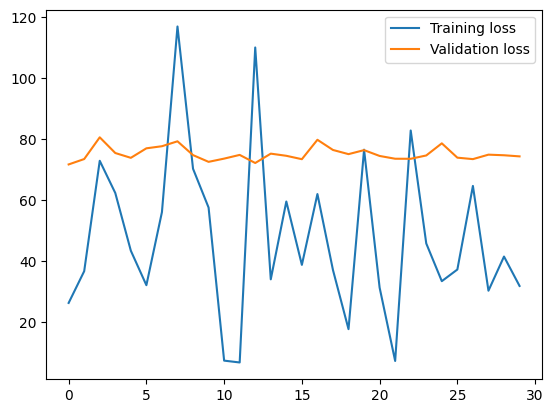

Test Loss: 74.25189347494216
Mean Squared Error: 244.0454
R2 Score: -1.8579990735134033
Mean Absolute Error: 12.9311905
Test MSE: 244.0454
Test R2: -1.8579990735134033
Test MAE: 12.9311905
Mean Absolute Error: 12.93
Accuracy: -inf %.
Mean Squared Error: 244.05
Root Mean Squared Error: 15.62
R2: -1.86


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


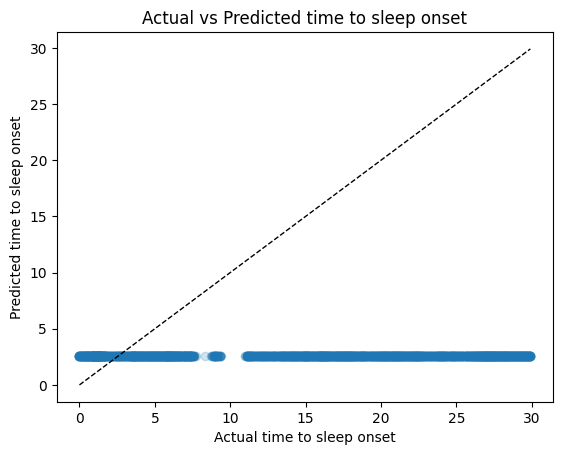

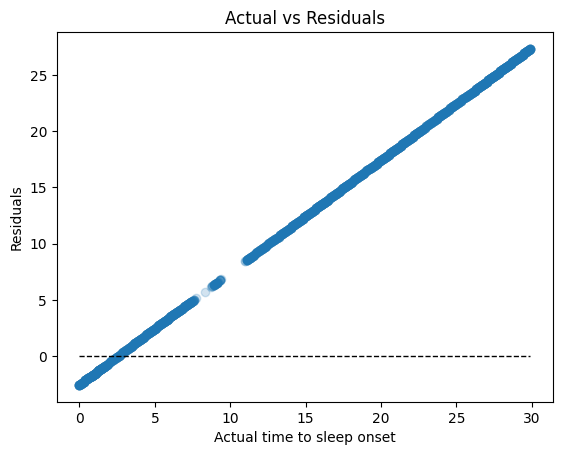

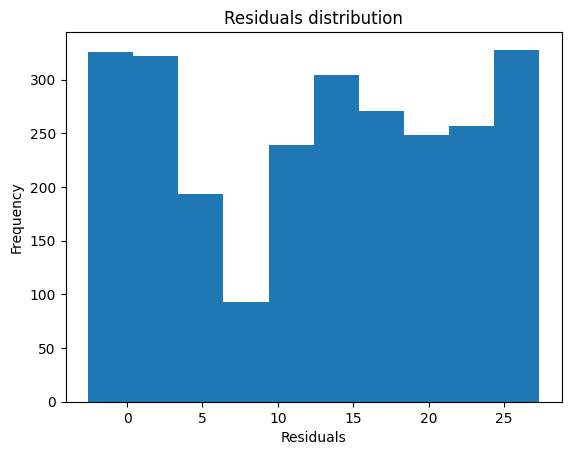

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


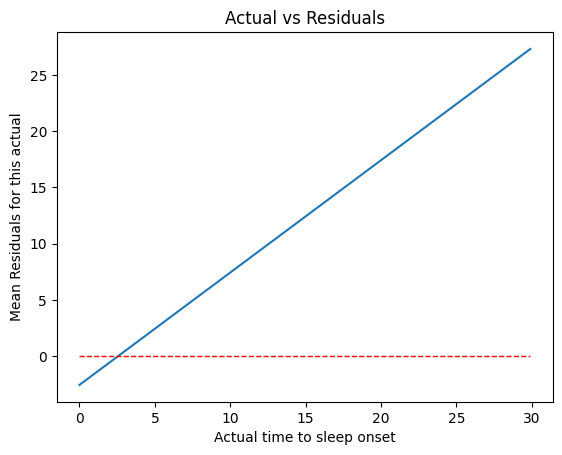

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


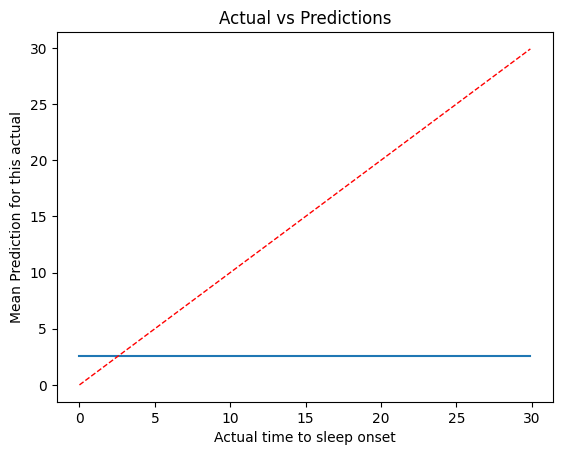

([26.234479904174805,
  36.63465118408203,
  72.80682373046875,
  62.24940872192383,
  43.347320556640625,
  32.052703857421875,
  55.98398971557617,
  116.80815124511719,
  70.19960021972656,
  57.48744583129883,
  7.33960485458374,
  6.731685161590576,
  109.92959594726562,
  33.97188186645508,
  59.46989059448242,
  38.70783996582031,
  61.91083908081055,
  37.024105072021484,
  17.64413070678711,
  76.44525909423828,
  31.26015853881836,
  7.22847843170166,
  82.73261260986328,
  45.727298736572266,
  33.36505889892578,
  37.185874938964844,
  64.56635284423828,
  30.24408721923828,
  41.43696212768555,
  31.80103874206543],
 [71.61223484220959,
  73.37621548062279,
  80.49711846169971,
  75.35139817283267,
  73.7750047729129,
  76.89206436702183,
  77.57771519252232,
  79.18814793087188,
  74.66683153879075,
  72.46042496817452,
  73.51872628075736,
  74.73274458022345,
  72.0833371480306,
  75.14628542037238,
  74.443069594247,
  73.33066231863839,
  79.69077251071022,
  76.35207

In [51]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 30, l2 = 0, lr = 0.001, weight_decay = 0.05, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=3, iftest=False, ifoutputpredictions=0, 
                                       ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELoss(), iftrainshuffle=True)

There are 278 subjects in the training set, 31 subjects in the validation set and 0 subjects in the test set
Epoch 1/16
----------------------------------------------------------------------------------------------------
Epoch 1/16, Loss: 83.32622528076172, Validation Loss: 55.140529600941406
Val Mean Squared Error: 182.1952667236328, Val R2 Score: -1.2942314209022951
Epoch 2/16
----------------------------------------------------------------------------------------------------
Epoch 2/16, Loss: 108.15864562988281, Validation Loss: 63.2384676472569
Val Mean Squared Error: 222.0835723876953, Val R2 Score: -1.7965109516824653
Epoch 3/16
----------------------------------------------------------------------------------------------------
Epoch 3/16, Loss: 33.99091720581055, Validation Loss: 52.02213574915516
Val Mean Squared Error: 160.5968017578125, Val R2 Score: -1.0222598706945383
Epoch 4/16
------------------------------------------------------------------------------------------------

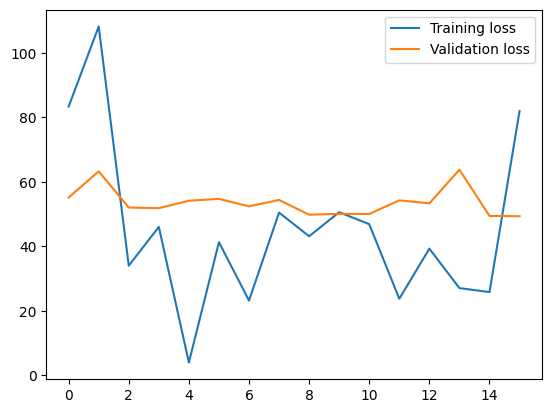

Test Loss: 49.326826462940296
Mean Squared Error: 159.47063
R2 Score: -1.0080790447295134
Mean Absolute Error: 10.150284
Test MSE: 159.47063
Test R2: -1.0080790447295134
Test MAE: 10.150284
Mean Absolute Error: 10.15
Accuracy: -inf %.
Mean Squared Error: 159.47
Root Mean Squared Error: 12.63
R2: -1.01


/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = 100 * (errors / y_test)


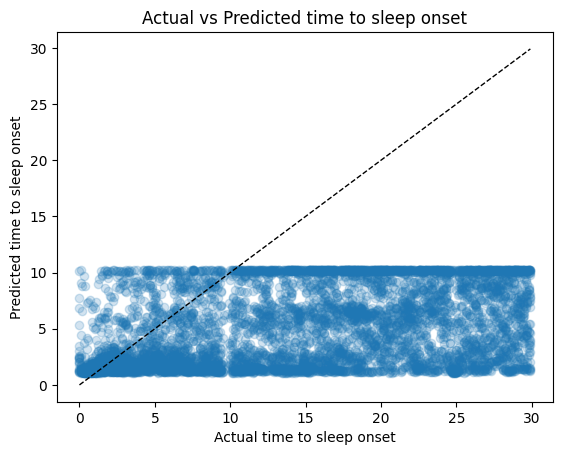

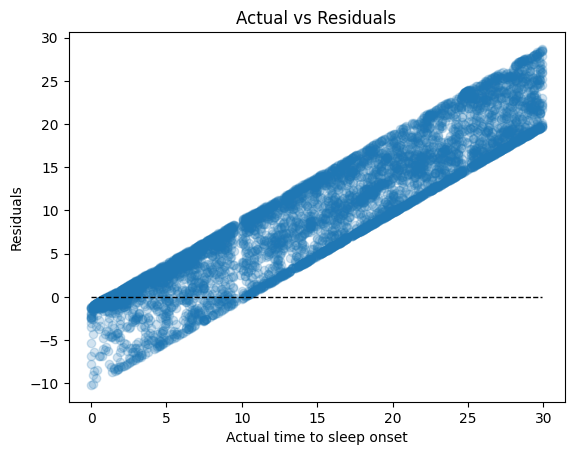

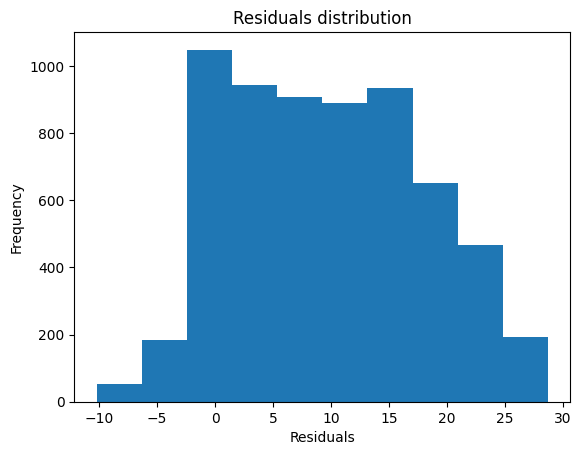

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:110: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [0, 0], 'k--', lw=1, color='red')


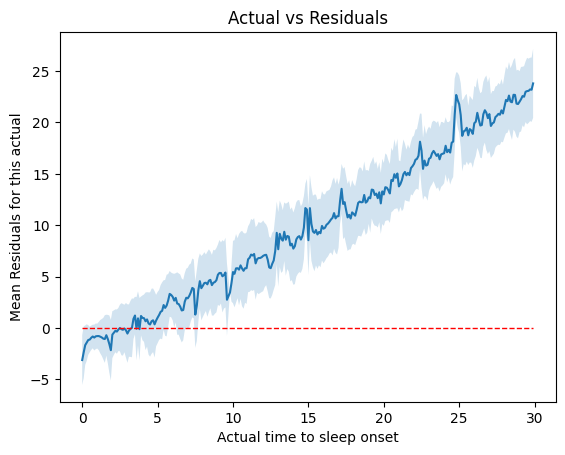

/var/folders/4z/0d9t18bj63v8jxhgj_4bvm0r0000gn/T/ipykernel_36314/4047173633.py:123: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1, color='red')


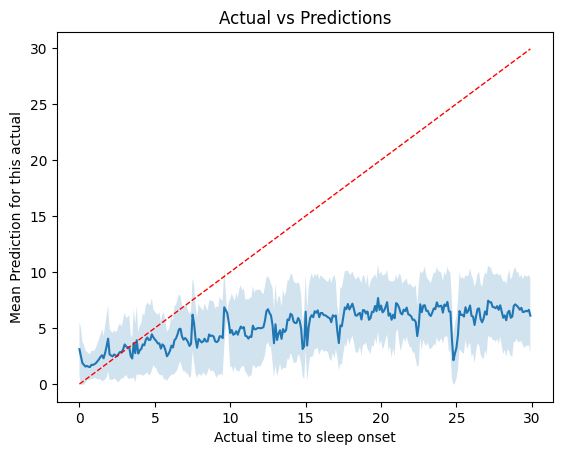

([83.32622528076172,
  108.15864562988281,
  33.99091720581055,
  46.020843505859375,
  3.9779767990112305,
  41.276180267333984,
  23.183963775634766,
  50.4486198425293,
  43.11587142944336,
  50.56378936767578,
  46.85407638549805,
  23.732318878173828,
  39.26918411254883,
  27.02928352355957,
  25.805648803710938,
  81.9250259399414],
 [55.140529600941406,
  63.2384676472569,
  52.02213574915516,
  51.82070346754424,
  54.132893031957195,
  54.69535948548998,
  52.40175565894769,
  54.371652340402406,
  49.79819537182244,
  50.05412856656678,
  50.027623439321715,
  54.2507135211205,
  53.31790399064823,
  63.760159876881815,
  49.4155465413113,
  49.326826462940296],
 SleepOnsetTransformerRegressor(
   (embedding): Linear(in_features=86, out_features=512, bias=True)
   (positional_encoding): PositionalEncoding(
     (dropout): Dropout(p=0.0, inplace=False)
   )
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0-1): 2 x TransformerEncoderLayer(
    

In [52]:
training_loop_feature_RNN_regression(data_clean_onset, filling_limit = 0, method = None, input_size = 86, nhead = 8,
                                        num_layers = 2, num_epochs = 16, l2 = 0, lr = 0.0001, weight_decay = 0.5, batch_size = 128, device = device, 
                                        random_seed=42, window_size_minutes=0.5, iftest=False, ifoutputpredictions=0, 
                                         ifplot=True, ifsaveplots=True, output_path=None, loss_function=CustomMSELoss(), iftrainshuffle=True)